In [1]:
# General imports
import sys
import math
import pandas as pd
import numpy as np
from datetime import datetime,timedelta,date
from pathlib import Path
import warnings
from typing import Callable, List, Tuple
import random
# Statistics
import scipy.stats as stats
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
# Library to do time series decomposition
import statsmodels.api as sm
# Module to create ACF and PACF plots
from statsmodels.graphics import tsaplots
# Module to build AR, MA, ARMA, and ARIMA models
# from statsmodels.tsa.arima.model import ARIMA
# Module to implement MSE and RSME during model evaluation
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# (S)ARIMA(X) models
from pmdarima.arima import auto_arima, ARIMA
# Autogluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
# Set the random seed for reproducibility
np.random.seed(42)
# Interpretability
import shap

In [2]:
import torch; torch.cuda.is_available()

True

In [3]:
# Functionality to allow the notebook to run locally or in Colab
# This needs to be adjusted to the local or colab path where the data is stored
COLABPATH = "/content/drive/MyDrive/Colab Notebooks/predict_effective_temperature"
LOCALPATH = "."
# Installation of the required packages on Colab
try:
  import google.colab
  from google.colab import drive
  if not Path('/content/drive').exists():
    drive.mount('/content/drive')
  path = Path(COLABPATH)
except ModuleNotFoundError:
    print("Running in local environment")
    path = Path(LOCALPATH)
    
if (pd.__version__ > '2.1.0'):
    warnings.simplefilter(action='ignore', category=FutureWarning)


Running in local environment


# PREDICTING TEMPERATURE SENSATION IN A POULTRY BARN

Meat chickens, also called broilers, in intensive rearing live in closed, controlled environment for about 36-42 days (depending on the target market) before they are brought to the abattoir. During this time, the thermal environment is very important, as chickens have no sweat glands and are prone to suffer from both cold and hot temperatures. Chickens manage their core temperature through heat exchange via their feet and their respiration, but are able to do so only after about 10 days of life. The so-called *thermo-neutral* zone of a chicken, i.e. the thermal range that allows a chicken to maintain a constant core temperature grows over time - the exact ranges are not currently known.

Chickens like humans are affected not only by temperature: humidity also plays a great role. The higher the humidity, the more extreme temperature is perceived, because the higher water contents in the air conducts the heat better. Air flow or air speed also pays an important role: the higher the air speed, the colder it feels. This is called the *windchill effect*. For chickens, our best measure currently is called the *effective temperature* and is a combination of temperature, relative humidity and airspeed.

In order to cater for the different needs of birds during their lifetime, farmers have targets for temperature, relative humidity and some also for airspeed.

Modern barns operate heating and cooling elements automatically via sensor input. The so-called "controller", essentially a computer, uses inputs from sensors and translates them into actions: starting/stopping the heater, ventilators, air flaps and cooling elements. In essence, the controller compares the sensor input to the targets and decides on the action to be taken based on that information. Given that farms are quite large spaces (2,500m$^2$ x 3m height = 7,500m$^3$ is not atypical), controllers try to anticipate changes in the ambient conditions to avoid reaching suboptimal conditions for the animals.

In cold weather, farms try to ventilate less - because then they have to heat the entering cold air which increases the cost of production. In hot weather, farmers use laminar ventilation (called "tunnel ventilation") to employ the windchill effect in cooling down the birds. Farms in hot climate also operate heat exchangers or coolers to mitigate outside conditions.

If controllers were perfect and barns were perfect, the ambient conditions inside would be indentical with the targets. However, that is not true. The sun, for example, has significant impact by heating up the barn; this triggers higher ventilation rates and lower temperatures (or effective temperatures) in the afternoons. At the same time, while heating does change the relative humidity (it dries the air), heating is expensive. If the outside relative humidity is too high, but the temperature is acceptable, controllers will allow for a higher relative humidity. As controller typically do not operate on effective temperature, this means that the thermal sensation will be stronger (colder or hotter).

Controllers heat and cool the environment based on sensor input. However, the change of the temperature sensation in the barn is slow, so predicting the conditions some hours in advance will allow controllers to slowly ramp up their heating and cooling and therefore save energy while maintaining the barn always at optimum conditions.

## Problem statement

This is **Part 2** of the analysis of the thermal sensation in a chicken barn. In Part 1, a correlation analysis and linear regression was undertaken to understand the impact of outside conditions on the thermal sensation as measured by the *effective temperature*. 

The goal of this notebook is to:
1) Analyse the problem from a timeseries perspective
2) Build a predictor of the effective temperature that is capable of predicting the effective temperature inside the barn 4-12h in advance with an error <2ºC

Three data sets are available (two for training and one for testing).


## Is this a timeseries problem or a (non-linear) regression problem?

The question says it all: in principle, chickens are raised in (discontinuous) flocks. In the absence of outside influence, flocks are *meant* to be identical, i.e. every day of production should find the same stage of development and therefore the same thermal needs of the birds. Therefore the thermal conditions should be the same. We can allow for some outside influence by weather, but that should really explain all the differences. This points toward a regression problem.

On the other hand, there is a variety of variables that exist but we have no access to. Farmers might change the settings of their climate system, the response of such system might not be linear and there might be weather factors (such as hours and intensity of sunlight) that we have no access to. Also, we have no knowledge how the farmers adapts to changes in genetics of the birds and/or advice by external consultants, vets etc. In addition, it is very clear that conditions in the farm are autoregressive. None of the conditions change very fast, so clearly e.g. the temperature at time $t$ is correlated with the temperature at times $t-n$. For these reasons, we could look at this as a (discontinuous) timeseries problem.

We will try out both. For the timeseries "formulation" we will tack on one timeseries to another, thereby creating an artificial, continuous timeseries. For the prediction, we will have to translate timestamps back to the original time. For the regression approach we will include the autoregression by adding past values as features into the data set.

## Preparation of the dataset

In [4]:
# Running the data set preparation or if the prepared data set exists, loading it

basepath = path/"data"
   
FLOCK_1 = "hmkrkyw"
FLOCK_2 = "dqnjrym"
FLOCK_3 = "kkeesgc"

dataset_1 = basepath/(FLOCK_1 + '.parquet')
dataset_2 = basepath/(FLOCK_2 + '.parquet')
dataset_3 = basepath/(FLOCK_3 + '.parquet')
if not basepath.exists() or not dataset_1.exists() or not dataset_2.exists():
    print("The required data sets are not available")
    sys.exit(1) 
else:
    df_hmkrkyw = pd.read_parquet(dataset_1)
    df_dqnjrym = pd.read_parquet(dataset_2)
    df_kkeesgc = pd.read_parquet(dataset_3)

In [5]:
df_hmkrkyw.sample(10)

,date,hour,day_of_production,ET,T,RH,AH,AS,CO2,weight,...,rh,ah,ws,wd,pc,p,t_ET,t_T,t_RH,t_AS
time,,,,,,,,,,,,,,,,,,,,,
2022-09-10 13:00:00,2022-09-10,13,37,23.393108,24.326316,75.0,16.633818,0.847368,657.315789,2391.052632,...,37.0,11.050668,3.59,226.0,0.0,1017.07,23.268662,22.714286,65.000000,0.2
2022-08-24 00:00:00,2022-08-24,0,20,26.420299,26.900000,67.0,17.162721,0.900000,649.000000,893.000000,...,66.0,12.316277,3.82,160.0,0.0,1014.29,25.852070,25.285714,63.714286,0.2
2022-08-11 12:00:00,2022-08-11,12,7,31.142839,32.400000,39.0,13.464401,0.800000,510.000000,204.000000,...,24.0,10.093698,3.95,185.0,0.0,1013.90,28.481598,28.000000,60.000000,0.2
2022-08-21 09:00:00,2022-08-21,9,17,27.076691,26.800000,60.0,15.284607,0.200000,769.000000,688.000000,...,36.0,11.373313,2.68,258.0,0.0,1016.13,26.695718,26.142857,62.857143,0.2
2022-08-07 10:00:00,2022-08-07,10,3,31.733258,31.400000,53.0,17.347699,0.200000,667.000000,97.000000,...,31.0,11.998436,1.92,204.0,0.0,1015.28,30.105981,29.714286,57.142857,0.2
2022-08-10 07:00:00,2022-08-10,7,6,30.038328,29.950000,48.5,14.676537,0.200000,950.500000,173.000000,...,36.0,12.186468,2.36,182.0,0.0,1017.31,28.887694,28.428571,59.285714,0.2
2022-08-23 21:00:00,2022-08-23,21,19,28.066475,27.800000,63.5,17.095242,0.450000,549.750000,822.000000,...,62.0,13.053399,6.54,171.0,0.0,1013.62,26.133286,25.571429,63.428571,0.2
2022-08-23 12:00:00,2022-08-23,12,19,26.259575,27.500000,56.0,14.828931,1.000000,648.500000,822.000000,...,35.0,11.407062,2.87,208.0,0.0,1014.00,26.133286,25.571429,63.428571,0.2
2022-08-08 04:00:00,2022-08-08,4,4,31.373136,30.700000,63.5,20.018128,0.200000,1909.000000,120.000000,...,53.0,10.956700,1.65,161.0,0.0,1014.95,29.699886,29.285714,57.857143,0.2


In [6]:
def calculate_relative_humidity(p: float, T: float, AH: float) -> float:
    """
    Calculate the relative humidity.

    Args:
        p (float): The atmospheric pressure in hPa.
        T (float): The temperature in degrees Celsius.
        AH (float): The absolute humidity in g/m³.

    Returns:
        float: The relative humidity in percent.
        
    Reference:
        https://planetcalc.com/2167/
        https://planetcalc.com/2161/

    """
    AH /= 1000  # Convert g/m³ to kg/m³
    # Calculate saturation vapor pressure (using T in ºC)
    ew = 6.112 * math.exp((18.678 - T / 234.5) * T / (T + 257.14)) * (1.0016 + 3.15e-6 * p + 0.074 / p)
    # And now the relative humidity
    Rv = 4.615  # J/(kg K) specific gas constant for water vapor
    RH = 100 * (AH / ew) * Rv * (T + 273.15)
    # Return the relative humidity
    return RH

In [7]:
specs = {'ET': 'ET inside','T':'T inside', 'RH': 'RH inside','AH': 'AH inside', 'AS': 'air speed', 'CO2':'CO2 inside', 'weight':'weight',
            'et': 'ET outside','t': 'T outside', 'rh': 'RH outside', 'ah':'AH outside','ws': 'wind speed', 'wd': 'wind direction', 'pc': 'precipitation', 'p': 'air pressure',
            't_ET': 'ET target','t_T':'T target', 't_RH': 'RH target', 't_AS': 'AS target'}
features = specs.keys()

**The feature set**

| Feature | Explanation |
|---------|-------------|
| time | Timestamp (datetime) of the data point. Original measurements have been reduced to one data point per hour (median) |
| date | Date (datetime.date) of the data point|
| hour | Hour of the day (int) |
| day_of_production| The so-called day of production which is zero at chick placement and then increments by one every calendar day|
| ET | The calculated effective temperature in ºC |
| T | Temperature in ºC |
| RH | Relative humidity inside in %|
| AH | Absolute humidity inside in kg/m$^3$ |
| AS | Air speed in m/s |
| CO2 | The CO$_2$ contents in the air in ppm |
| weight| Target weight of ROSS 308 broilers on the day of production |
| et | Calculated outside effective temperature at ($v$=0)|
| t | Outside temperature in ºC |
| rh | Outside relative humidity in %|
| ah | Absolute humidity outside in kg/m$^3$ |
| ws | Windspeed in m/s|
| wd | Wind direction in º |
| pc | Precipitation in mm|
| p | Outside athmospheric pressure |
| t_T | target temperature in the barn |
| t_RH | target relative humidity in the barn |
| t_AS | target airspeed |
| t_ET | calculated target effective temperature |



## Exploratory data analysis (EDA)

We don't anticipate that the targets for relative humidity, air speed and temperature will be individually relevant, so we retain only the target for effective temperature. We also remove the relative humidity from the data set, as we have the temperature-independent absolute humidity.

In [8]:
df_hmkrkyw[features].describe().T

,count,mean,std,min,25%,50%,75%,max
ET,965.0,27.326900,3.162719,19.739030,24.932504,27.017693,29.086960,36.071885
T,965.0,27.896192,2.958693,21.900000,25.500000,27.500000,29.650000,36.700000
RH,965.0,55.167358,11.694824,29.000000,46.000000,56.000000,64.000000,81.000000
AH,965.0,14.796066,2.530739,7.289332,13.198803,14.928287,16.709190,21.596552
AS,965.0,0.594041,0.376116,0.000000,0.200000,0.600000,0.900000,1.600000
CO2,965.0,689.238342,200.515988,401.000000,573.000000,643.000000,735.250000,2348.000000
weight,965.0,1063.517617,806.264647,42.000000,315.000000,893.000000,1725.000000,2674.000000
et,965.0,26.099423,4.419459,16.189387,22.465424,25.490628,29.611141,37.525527
t,965.0,25.761710,5.047764,15.060000,21.660000,24.970000,29.730000,39.170000
rh,965.0,48.290674,15.889858,19.000000,36.000000,46.000000,60.000000,96.000000


In [9]:
df_dqnjrym[features].describe().T

,count,mean,std,min,25%,50%,75%,max
ET,912.0,25.929553,2.729894e+00,20.836200,23.495077,25.208875,28.575303,33.069223
T,912.0,26.172889,2.590763e+00,20.350000,24.219643,25.159091,28.466667,33.300000
RH,912.0,45.441338,1.057782e+01,25.000000,36.132353,48.500000,53.000000,67.000000
AH,912.0,11.283929,3.141877e+00,6.494627,8.638457,11.868800,13.757584,19.263218
AS,912.0,0.232292,1.563175e-01,0.000000,0.100000,0.200000,0.300000,1.300000
CO2,912.0,1287.274397,5.113528e+02,526.000000,830.968750,1235.555556,1592.375000,3377.000000
weight,912.0,1077.321272,7.721480e+02,77.000000,359.000000,966.000000,1711.336310,2674.000000
et,912.0,15.796161,5.323304e+00,0.658514,11.920526,15.456694,19.869165,29.762481
t,912.0,15.045800,5.999241e+00,-0.850000,10.592500,14.620000,19.807500,30.520000
rh,912.0,55.242325,2.340235e+01,11.000000,35.000000,52.000000,76.000000,98.000000


In [10]:
# Simple function to show a time series of ET, T and AH outside/inside and with target
def timeplot(df:pd.DataFrame,xvar:str='date'):
    fig, axs = plt.subplots(1, 3, figsize=(30, 6))

    sns.lineplot(data=df,x=xvar, y='ET', label=specs['ET'], ax=axs[0],legend=True)
    sns.lineplot(data=df,x=xvar, y='et', label=specs['et'], ax=axs[0],legend=True)
    sns.lineplot(data=df,x=xvar, y='t_ET', label=specs['t_ET'], ax=axs[0],legend=True)
    axs[0].set_title('Effective Temperature')
    axs[0].tick_params("x", labelrotation=45)
    #
    sns.lineplot(data=df,x=xvar, y='T', label=specs['T'], ax=axs[1],legend=True)
    sns.lineplot(data=df,x=xvar, y='t', label=specs['t'], ax=axs[1],legend=True)
    sns.lineplot(data=df,x=xvar, y='t_T', label=specs['t_T'], ax=axs[1],legend=True)
    axs[1].set_title('Temperature')
    axs[1].tick_params("x", labelrotation=45)

    sns.lineplot(data=df,x=xvar, y='AH', label=specs['AH'], ax=axs[2],legend=True)
    sns.lineplot(data=df,x=xvar, y='ah', label=specs['ah'], ax=axs[2],legend=True)
    # sns.lineplot(data=df,x=xvar, y='t_RH', label=targets_features['t_RH'], ax=axs[2],legend=True)
    axs[2].set_title('Absolute Humidity')
    axs[2].tick_params("x", labelrotation=45)
    

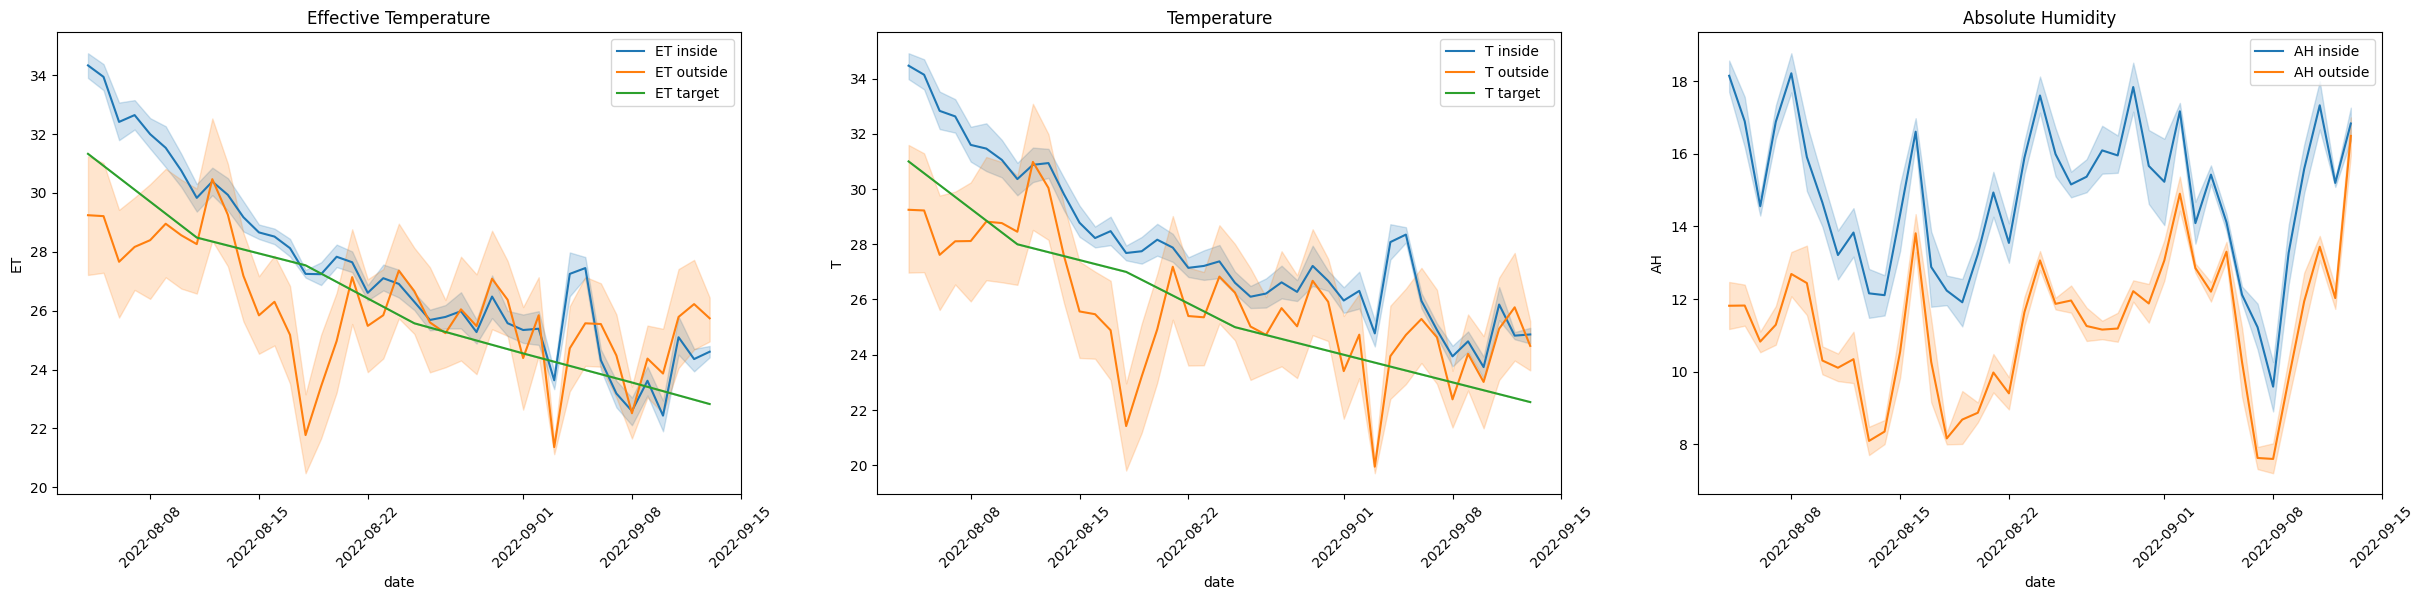

In [11]:
# Show ET, T and AH for each day
timeplot(df_hmkrkyw)

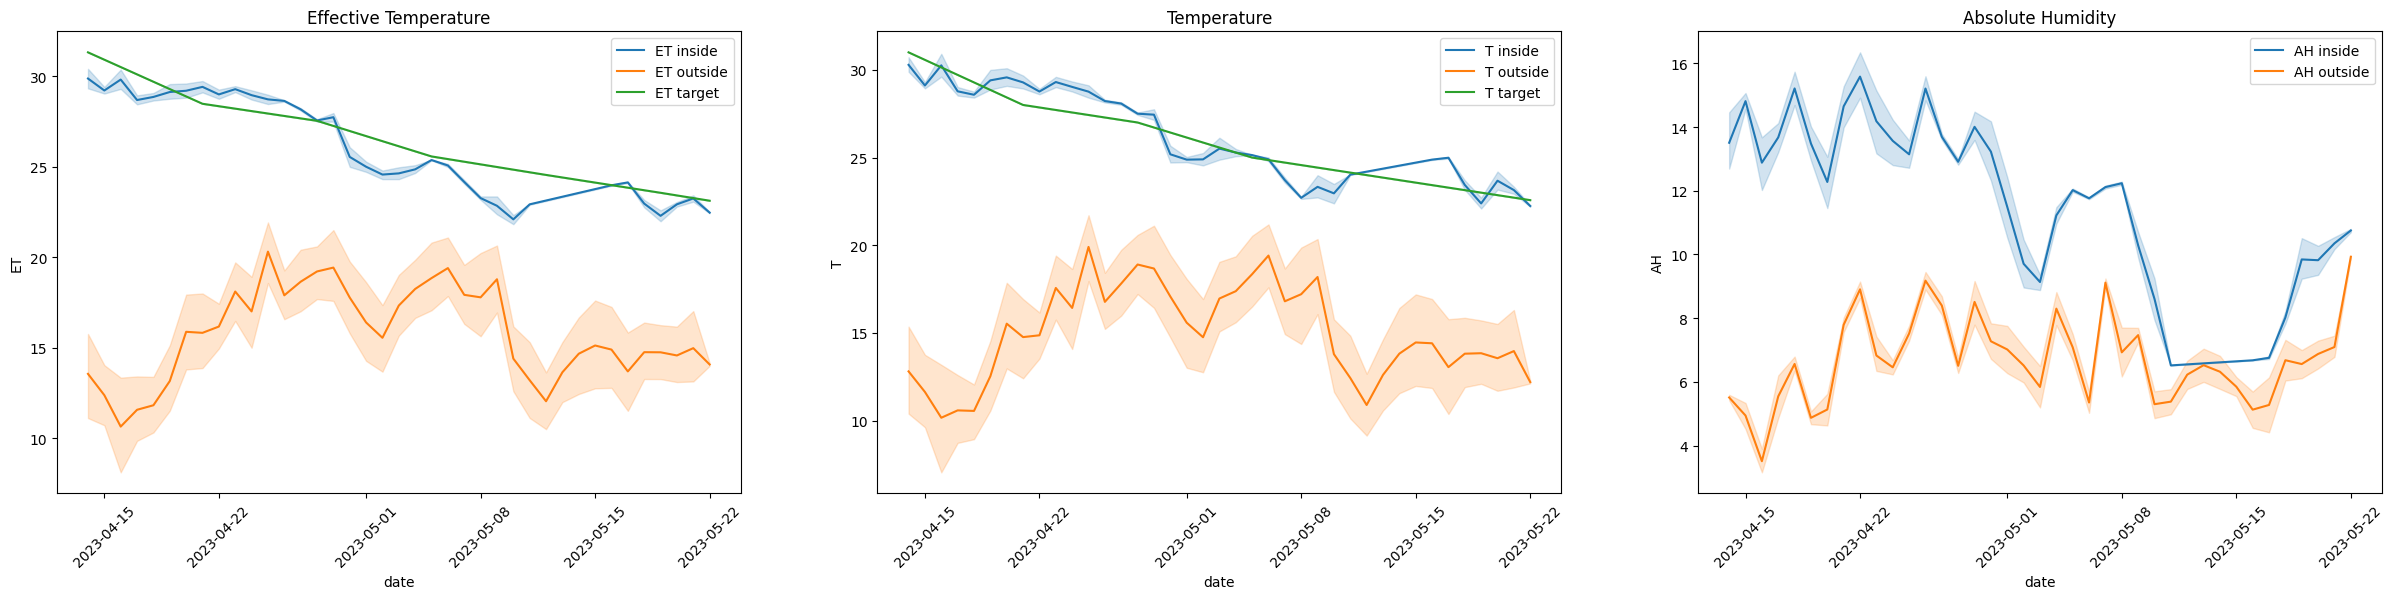

In [12]:
timeplot(df_dqnjrym)

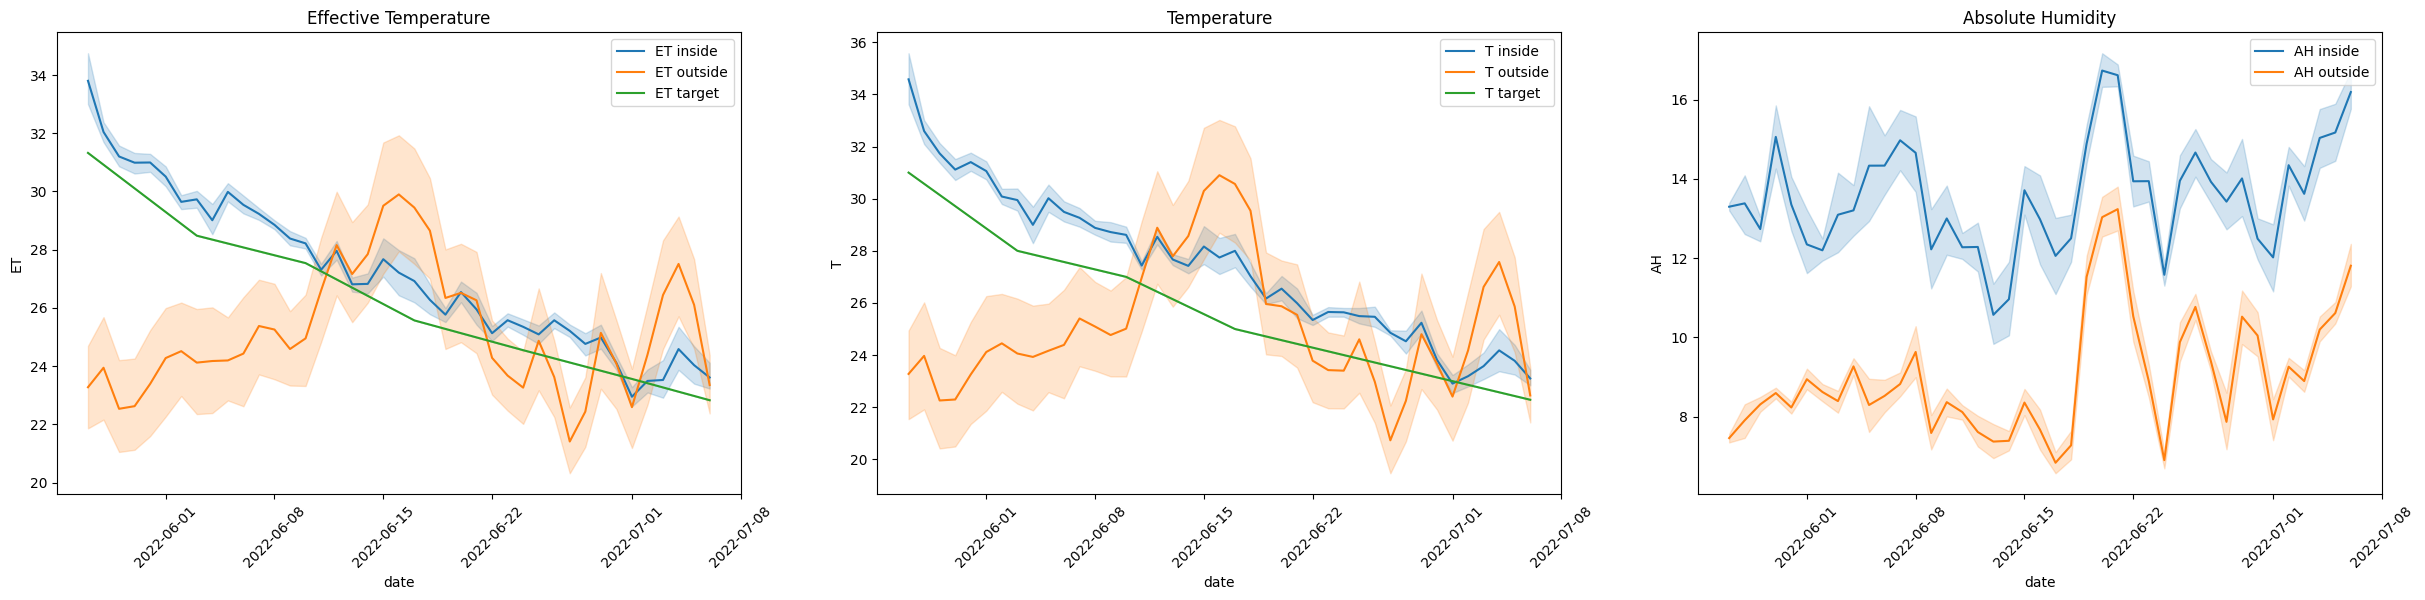

In [13]:
timeplot(df_kkeesgc)

# Timeseries analysis

The effective temperature is an analytical function of the temperature, relative humidity and air speed. Relative humidity is temperature dependent, so we included the non-temperature-dependent absolute humidity in the data set. For both heat and absolute humidity conservation rules can be formulated (see Part 1 of this analysis).

In part 1 we directly modeled the effective temperature in dependence of inside and outside factors. Here we will analyse temperature and humidity separately and later calculate from the predictions the effective temperature.

In [14]:
def adfuller_test(df):
    """
    Perform the Augmented Dickey-Fuller test on a given time series.

    Parameters:
    df (pandas.DataFrame): The time series data to be tested.

    Returns:
    None
    """

    adftest = adfuller(df)
    print(f'ADF Statistic: {adftest[0]:.3f}')
    print(f'p-value: {adftest[1]:.3e}')
    print('Critical Values:')
    for key, value in adftest[4].items():
        print(f'\t{key}: {value:.3f}')

In [15]:
def remove_daily_trend(df:pd.DataFrame,feature:str,new_feature:str, rolling:bool=True, window=24)->pd.DataFrame:
    """
    Removes the daily trend from a given feature in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        feature (str): The name of the feature to remove the daily trend from.
        new_feature (str): The name of the new feature to store the detrended values.
        rolling (bool, optional): Whether to use rolling median or daily median. Defaults to True.
        window (int, optional): The window size for rolling median. Defaults to 24.

    Returns:
        pd.DataFrame: The DataFrame with the daily trend removed.
    """
    if not rolling:
        df = df[['day_of_production',feature]].copy()
    elif isinstance(df,pd.DataFrame):
        df = df.copy()
    elif isinstance(df,pd.Series):
        df = df.to_frame()
    median_feature = "median_"+feature
    # 
    df[median_feature] = 0.0
    if rolling:
        df[median_feature]=df[[feature]].rolling(window=window).median()
        df.reset_index(inplace=True)
        df.loc[0:window-2,median_feature]=[df.loc[:i,feature].median() for i in range(window-1)]
        df.set_index('time',inplace=True)
        # df.asfreq('H')
    else:
        daily_median = df.groupby('day_of_production').median()
        for day in daily_median.index:
            df.loc[df['day_of_production']==day,median_feature] = daily_median.loc[day][feature]
    df[new_feature] = df[feature]-df[median_feature]
    return df

def plot_acf_pacf(dfs:list,cycleIds:list,feature:str,lags:int=24):
    fig, axs = plt.subplots(2, len(dfs), figsize=(20, 4*len(dfs)))
    for i,df in enumerate(dfs):
        plot_acf(df[feature], ax=axs[0,i],lags=lags)
        plot_pacf(df[feature], ax=axs[1,i],lags=lags)
        axs[0,i].set_title(f'{feature} ACF {cycleIds[i]}')
        axs[1,i].set_title(f'{feature} PACF {cycleIds[i]}')
        axs[0,i].set_xticks(range(0,lags+1))
        axs[1,i].set_xticks(range(0,lags+1))


## Temperature

### Internal temperature

ADF Statistic: -5.220
p-value: 8.017e-06
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
ADF Statistic: -4.315
p-value: 4.192e-04
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Statistic: -3.826
p-value: 2.651e-03
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


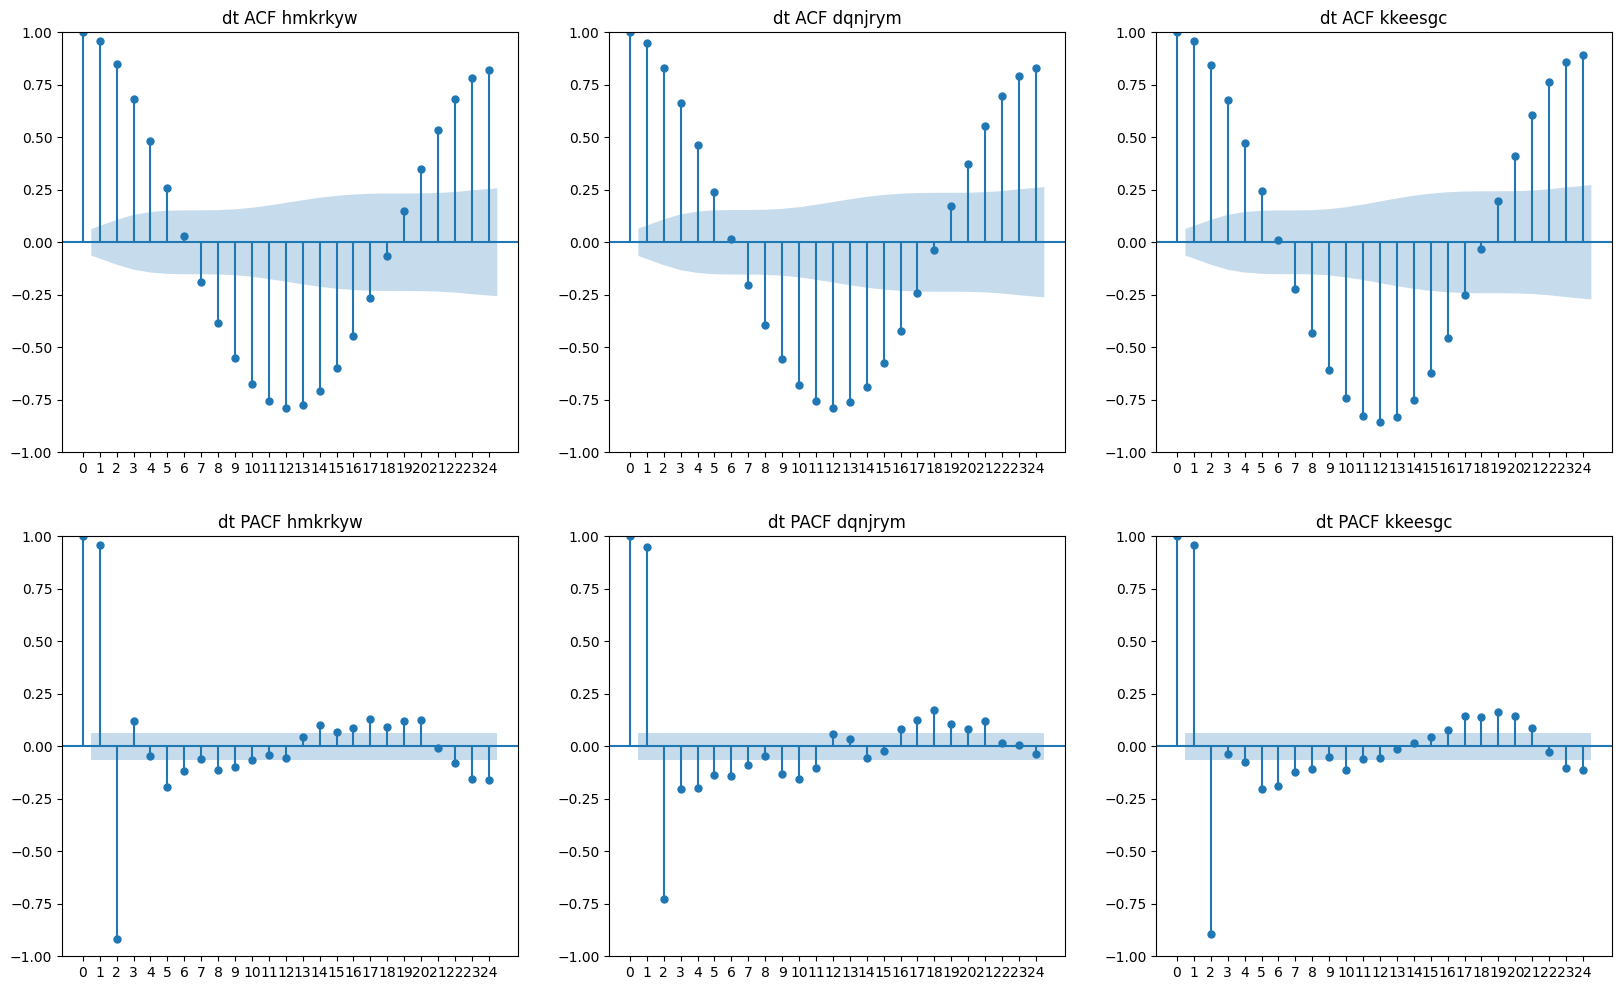

In [16]:
# Autocorrelation of the external temperature t
df_hmkrkyw_dt = remove_daily_trend(df_hmkrkyw.copy(),'t','dt')
df_dqnjrym_dt = remove_daily_trend(df_dqnjrym.copy(),'t','dt')
df_kkeesgc_dt = remove_daily_trend(df_kkeesgc.copy(),'t','dt')
adfuller_test(df_hmkrkyw_dt['dt'])
adfuller_test(df_dqnjrym_dt['dt'])
adfuller_test(df_kkeesgc_dt['dt'])
plot_acf_pacf([df_hmkrkyw_dt,df_dqnjrym_dt,df_kkeesgc_dt],['hmkrkyw','dqnjrym','kkeesgc'],'dt')

### Internal temperature

ADF Statistic: -4.003
p-value: 1.394e-03
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
ADF Statistic: -4.873
p-value: 3.930e-05
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Statistic: -4.578
p-value: 1.417e-04
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


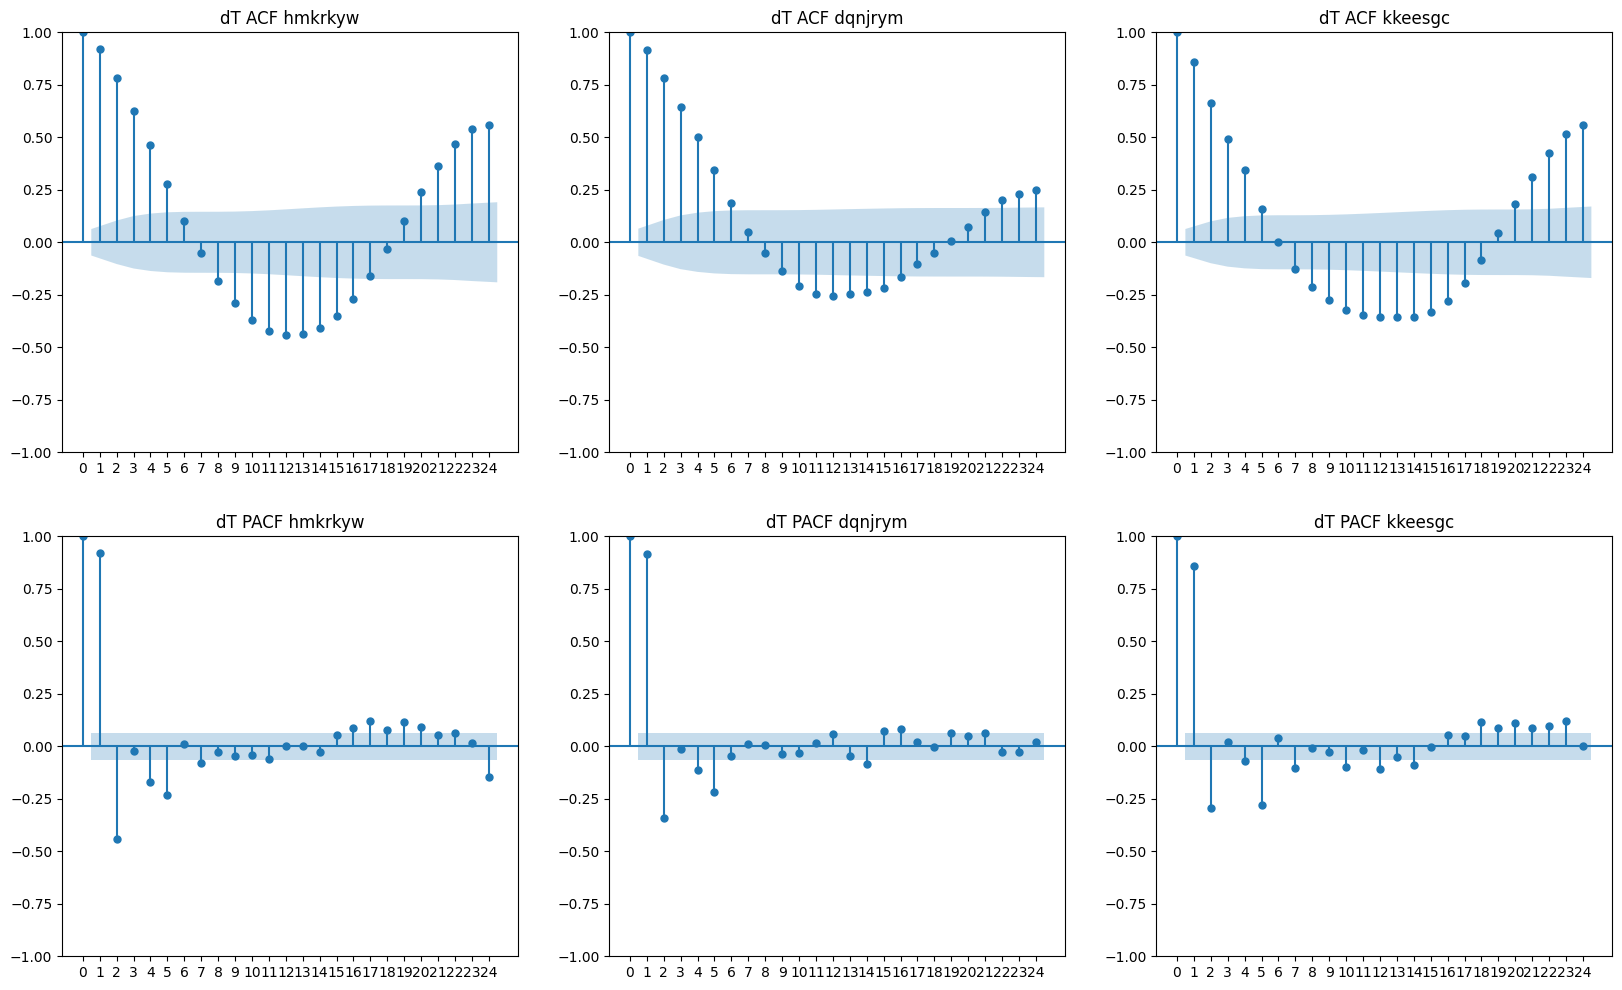

In [17]:
# Autocorrelation of the internal temperature T
df_hmkrkyw_dT = remove_daily_trend(df_hmkrkyw,'T','dT')
df_dqnjrym_dT = remove_daily_trend(df_dqnjrym,'T','dT')
df_kkeesgc_dT = remove_daily_trend(df_kkeesgc,'T','dT')
adfuller_test(df_hmkrkyw_dT['dT'])
adfuller_test(df_dqnjrym_dT['dT'])
adfuller_test(df_kkeesgc_dT['dT'])
plot_acf_pacf([df_hmkrkyw_dT,df_dqnjrym_dT,df_kkeesgc_dT],['hmkrkyw','dqnjrym','kkeesgc'],'dT')

**Observations**
- As can be seen from the partial autocorrelation function, the timeseries for both $\Delta t$ and $\Delta T$ are best represented by an autoregressive model and in both cases either an AR(2) or AR(5)
- By way of the Augmented Dickey-Fuller test, we see that the timeseries $\Delta t$ and $\Delta T$ are stationary
- There is a good chance that internal T autocorrelation depends to a good extent on outside t autocorrelation

### Modelling internal temperature

From the above we can deduct that the internal temperature T depends on $t_t ... t_{t-5}$. 

The task is now:
- Calculate  $t_t ... t_{t-5}$ for the three data sets
- Merge the data sets by placing them one after the other (keeping an identifier)
- Split the resulting data set into train and test data set
- Predict using Autogluon


In [18]:
class TimeSeriesModel:
    """
    A class representing an AutoGluon time series model. The class was created to store the predictions and access the relevant
    data later in the process.
    
    """
    
    _df: pd.DataFrame = None
    _train_data: pd.DataFrame = None
    _test_data: pd.DataFrame = None
    _cutoff: datetime.date = None
    _original_date_at_cutoff: datetime.date = None
    _excluded_features: list[str] = None
    _excluded_model_types: list[str] = None
    _eval_metric: str = None
    _path: str = None
    _predictor: TimeSeriesPredictor = None
    _train_timestamps: pd.DatetimeIndex = None
    _test_timestamps: pd.DatetimeIndex = None
    _prediction_length:int = 0
    _dataset_id:str = None
    
    _features: dict = None
    _target_feature: str
    
    def __init__(self, features: dict, target_feature: str, excluded_model_types, path: str,
                eval_metric: str = "RMSE", presets: str = "best_quality", time_limit: int = 1800, 
                random_seed: int = 42, dataset_id: str = "test"):
        """
        Initializes the TimeSeriesModel object.
        
        Args:
            features (dict): A dictionary mapping feature names to their descriptions.
            target_feature (str): The target feature to predict.
            excluded_model_types (list[str]): The list of model types to exclude from the model.
            path (str): The path to save the model.
            eval_metric (str, optional): The evaluation metric used for model performance. Defaults to "RMSE".
            presets (str, optional): The preset configuration for the model. Defaults to "best_quality".
            time_limit (int, optional): The time limit for model training in seconds. Defaults to 1800.
            random_seed (int, optional): The random seed for reproducibility. Defaults to 42.
            dataset_id (str, optional): The ID of the dataset. Defaults to "test".
        """
        self._excluded_model_types = excluded_model_types
        self._eval_metric = eval_metric
        self._features = features
        self._target_feature = target_feature
        self._path = path
        self._presets = presets
        self._time_limit = time_limit
        self._random_seed = random_seed
        self._dataset_id = dataset_id
        
    def get_train_data(self) -> pd.DataFrame:
        """
        Returns the training data.
        
        Returns:
            pd.DataFrame: The training data.
        """
        return self._train_data
    
    def get_test_data(self) -> pd.DataFrame:
        """
        Returns the test data.
        
        Returns:
            pd.DataFrame: The test data.
        """
        return self._test_data
        
    def set_dataset(self, dfs: list[pd.DataFrame], lag: int, excluded_features: list[str], cutoff: datetime.date):
        """
        Creates a dataset for training and testing by merging time series data from different data sets (pasting them
        behind each other) and adding time shifted features up to certain lag to the data set.
        
        Args:
            dfs (list[pd.DataFrame]): The list of dataframes to merge.
            lag (int): The lag for merging the time series data.
            excluded_features (list[str]): The list of features to exclude from the data.
            cutoff (datetime.date): The cutoff date for splitting the data into train and test sets.
        """
        self._df = TimeSeriesModel.merge_timeseries(dfs, self._target_feature.lower(), lag)
        self._df["dataset"] = self._dataset_id
        self._df['date'] = [idx.date() for idx in self._df.index]
        if not isinstance(cutoff, date):
            cutoff = date(cutoff)
        self._cutoff = cutoff
        self._original_date_at_cutoff = self._df.loc[self._df.index.date == self._cutoff,'original_time'].iloc[0].date()
        self._train_data = self._df[self._df.index.date < self._cutoff].reset_index()
        self._train_data = self._train_data.drop(columns=excluded_features)
        self._test_data = self._df[self._df.index.date >= self._cutoff].reset_index()
        self._test_data = self._test_data.drop(columns=excluded_features)

    def _get_train_test_data(self):
        """
        Returns the training and test data as TimeSeriesDataFrame objects.
        
        Returns:
            train_data (TimeSeriesDataFrame): The training data as a TimeSeriesDataFrame object.
            test_data (TimeSeriesDataFrame): The test data as a TimeSeriesDataFrame object.
        """
        train_data = TimeSeriesDataFrame.from_data_frame(
            self._train_data,
            id_column="dataset",
            timestamp_column="time"
        )

        test_data = TimeSeriesDataFrame.from_data_frame(
            self._test_data,
            id_column="dataset",
            timestamp_column="time"
        )
        return train_data, test_data     

    def get_original_date_at_cutoff(self) -> datetime.date:
        """
        Returns the original time at the cutoff date.
        
        Returns:
            datetime.date: The original time at the cutoff date.
        """
        return self._original_date_at_cutoff
    
    def model(self, prediction_length: int = 48) -> pd.DataFrame:
        """
        Trains the time series model and returns the predictor object.
        
        Args:
            prediction_length (int, optional): The length of the prediction horizon. Defaults to 48.
        
        Returns:
            pd.DataFrame: The trained predictor object.
        """
        self._prediction_length = prediction_length
        train_data, _ = self._get_train_test_data()
        
        covariate_features = self._train_data.columns.difference(['time','original_time',self._target_feature, 'dataset'])
        
        self._predictor = TimeSeriesPredictor(
            prediction_length=prediction_length,
            path=path,
            target=self._target_feature,
            eval_metric=self._eval_metric,
            freq="h",
            known_covariates_names=covariate_features,
        )
        self._predictor = self._predictor.fit(
            train_data,
            presets=self._presets,
            time_limit=self._time_limit,
            random_seed=self._random_seed,
            excluded_model_types=self._excluded_model_types
        )
        return self._predictor

    def forecast(self, historic_steps: int = 0) -> pd.DataFrame:
        """
        Generates forecasts using the trained model.
        
        Args:
            historic_steps (int, optional): The number of historic steps to include in the forecast. Defaults to 0.
        
        Returns:
            pd.DataFrame: The forecasted values.
        """
        train_data, test_data = self._get_train_test_data()
        
        future_index = get_forecast_horizon_index_ts_dataframe(train_data[[self._target_feature]], prediction_length=self._prediction_length, freq="H")
        self._future_timestamps = future_index.get_level_values("timestamp")
        covariate_features = train_data.columns.difference(['time','original_time', self._target_feature, 'dataset'])
        if historic_steps > 0:
            train_data = train_data.iloc[-historic_steps:]
            known_covariates = train_data[covariate_features]
            known_covariates = pd.concat(objs=[known_covariates, test_data.loc[(self._dataset_id, self._future_timestamps), covariate_features]])
        else:
            known_covariates = test_data.loc[(self._dataset_id, self._future_timestamps), covariate_features]
        predictions = self._predictor.predict(train_data, known_covariates=known_covariates)
        # Now get the original timestamp
        predictions['original_time'] = test_data.loc[(self._dataset_id,test_data.loc[(self._dataset_id)].index.isin(self._future_timestamps)),'original_time']
        # and return the predictions
        return predictions
        
    def plot_forecast(self, predictions):
        """
        Plots the forecasted values against the actual values.
        
        Args:
            predictions: The forecasted values.
        """
        # Create a subplot of 2 x 2
        plt.figure(figsize=(20, 6))
        label_1 = self._features[self._target_feature]
        label_2 = self._features[self._target_feature.lower()]
        sns.lineplot(data=self._df, x='date', y=self._target_feature, label=label_1)
        sns.lineplot(data=self._df, x='date', y=self._target_feature.lower(), label=label_2)
        # axs[0].set_title(f'{label_1} and {label_2}');
        timestamps = predictions.loc[self._dataset_id].index
        _, test_data = self._get_train_test_data()
        test_data_forecast = test_data.loc[(self._dataset_id,test_data.loc[(self._dataset_id)].index.isin(timestamps)),:]
        self._predictor.plot(test_data_forecast, predictions, quantile_levels=[0.1, 0.9])
    
    @staticmethod
    def shift_feature(df:pd.DataFrame, feature:str, periods:list[int])->pd.DataFrame:
        """
        Shifts a feature in a DataFrame by the given number of periods.

        Args:
            df 
            (pd.DataFrame): The DataFrame containing the feature to shift.
            feature (str): The feature to shift.
            periods (list[int]): List of periods to shift the feature by.

        Returns:
            pd.DataFrame: The DataFrame with the shifted feature.
        """
        for periods in periods:
            new_feature = f'{feature}m{periods}'
            df[new_feature] = df[feature].shift(periods)
        return df.fillna(0)
    
    @staticmethod
    def add_timeshifted_features(df:pd.DataFrame,feature:str,shifts:int=5)->pd.DataFrame:
        y = df.copy()
        y = TimeSeriesModel.remove_daily_trend(y,feature,f'd{feature}')
        y = TimeSeriesModel.shift_feature(y, feature, range(1,shifts+1))
        return y
    
    @staticmethod
    def merge_timeseries(dfs:list[pd.DataFrame],feature:str,shifts:int=5)->pd.DataFrame:
        result = pd.DataFrame()
        for idx, df in enumerate(dfs):
            df = TimeSeriesModel.add_timeshifted_features(df,feature,shifts)
            df['original_time'] = df.index
            if idx == 0:
                result = df
            else:
                # place this right after the last row of the previous data frame
                df['original_time'] = df.index
                df.index = df.index - df.index[0] + result.index[-1]+timedelta(days=1)
                result = pd.concat([result,df])
        return result

    @staticmethod
    def remove_daily_trend(df:pd.DataFrame,feature:str,new_feature:str, rolling:bool=True, window=24)->pd.DataFrame:
        """
        Removes the daily trend from a given feature in a DataFrame.

        Args:
            df (pd.DataFrame): The input DataFrame.
            feature (str): The name of the feature to remove the daily trend from.
            new_feature (str): The name of the new feature to store the detrended values.
            rolling (bool, optional): Whether to use rolling median or daily median. Defaults to True.
            window (int, optional): The window size for rolling median. Defaults to 24.

        Returns:
            pd.DataFrame: The DataFrame with the daily trend removed.
        """
        if not rolling:
            df = df[['day_of_production',feature]].copy()
        elif isinstance(df,pd.DataFrame):
            df = df.copy()
        elif isinstance(df,pd.Series):
            df = df.to_frame()
        median_feature = "median_"+feature
        # 
        df[median_feature] = 0.0
        if rolling:
            df[median_feature]=df[[feature]].rolling(window=window).median()
            df.reset_index(inplace=True)
            df.loc[0:window-2,median_feature]=[df.loc[:i,feature].median() for i in range(window-1)]
            df.set_index('time',inplace=True)
            # df.asfreq('H')
        else:
            daily_median = df.groupby('day_of_production').median()
            for day in daily_median.index:
                df.loc[df['day_of_production']==day,median_feature] = daily_median.loc[day][feature]
        df[new_feature] = df[feature]-df[median_feature]
        return df

In [19]:
excluded_model_types=['Chronos','RecursiveTabular','DirectTabular','SeasonalNaive','AutoARIMA','NPTS','AutoETS','CrostonSBA']
cutoff = date(2023, 8, 7)
data_sets = [df_dqnjrym,df_hmkrkyw,df_kkeesgc]

In [20]:
excluded_features = ['date','day_of_production','hour','ET','RH','AH','t_ET','t_T','t_RH','t_AS','weight','et','t','rh','ah','ws','wd','pc','p','AS','CO2']
path="AG-T-hourly"
target_feature = 'T'
lag = 5
T_tsm = TimeSeriesModel(specs,target_feature,excluded_model_types,path)
T_tsm.set_dataset(data_sets,lag,excluded_features,cutoff)
T_predictor = T_tsm.model()

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to 'AG-T-hourly'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          22
GPU Count:          1
Memory Avail:       15.63 GB / 31.51 GB (49.6%)
Disk Space Avail:   618.07 GB / 932.06 GB (66.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'excluded_model_types': ['Chronos',
                          'RecursiveTabular',
                          'DirectTabular',
                          'SeasonalNaive',
                          'AutoARIMA',
                          'NPTS',
                          'AutoETS',
                          'CrostonSBA'],
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['dt',
                            'median_t',
                           

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


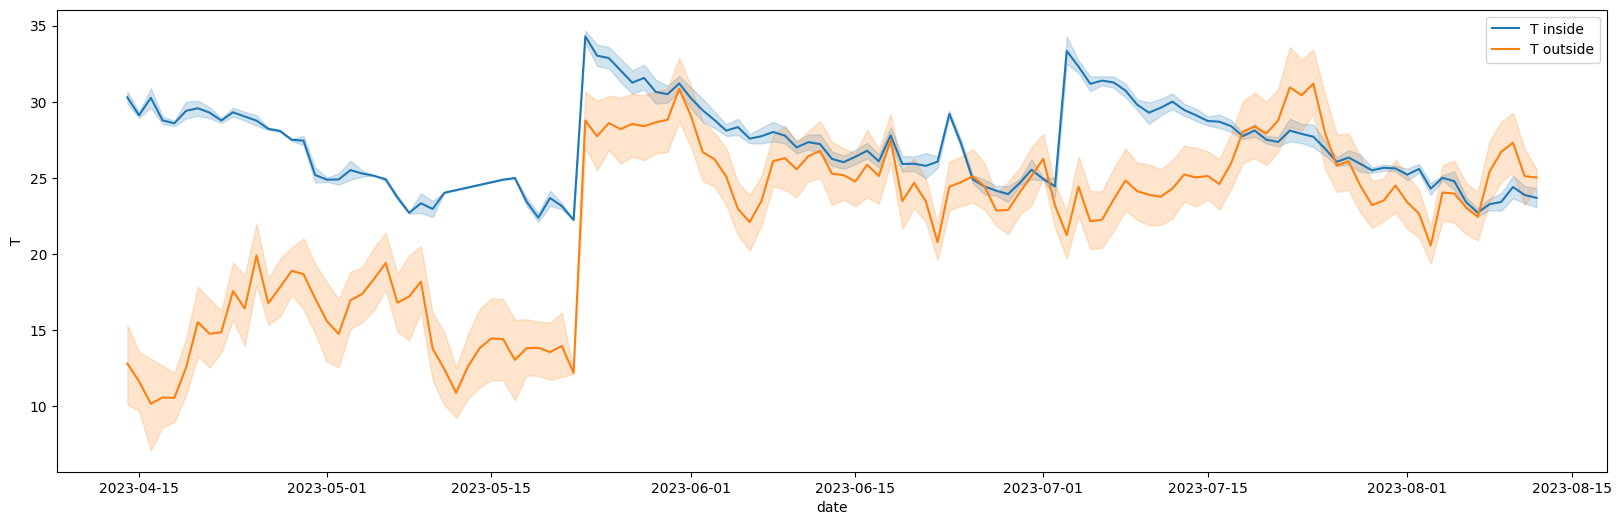

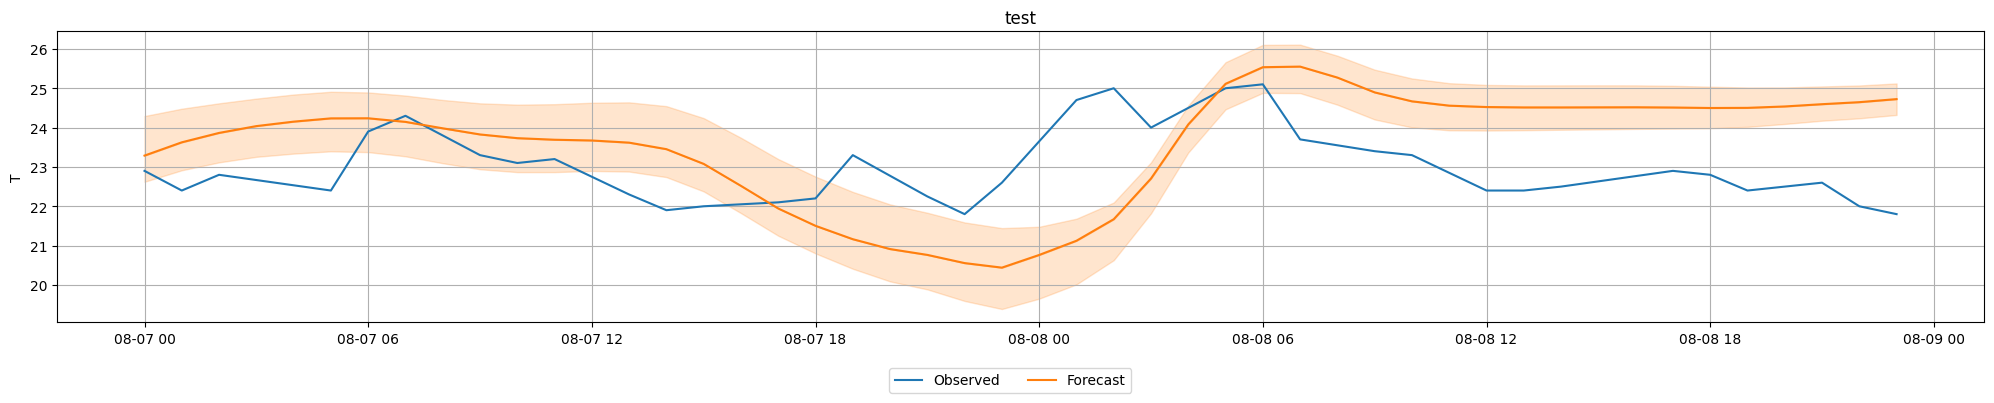

In [21]:
T_predictions = T_tsm.forecast(historic_steps=96)
T_tsm.plot_forecast(T_predictions)
# T_predictor, T_predictions = model_with_autogluon(data_sets,'T',5,specs,excluded_features,cutoff,excluded_model_types,path)

(21.5, 25.5)

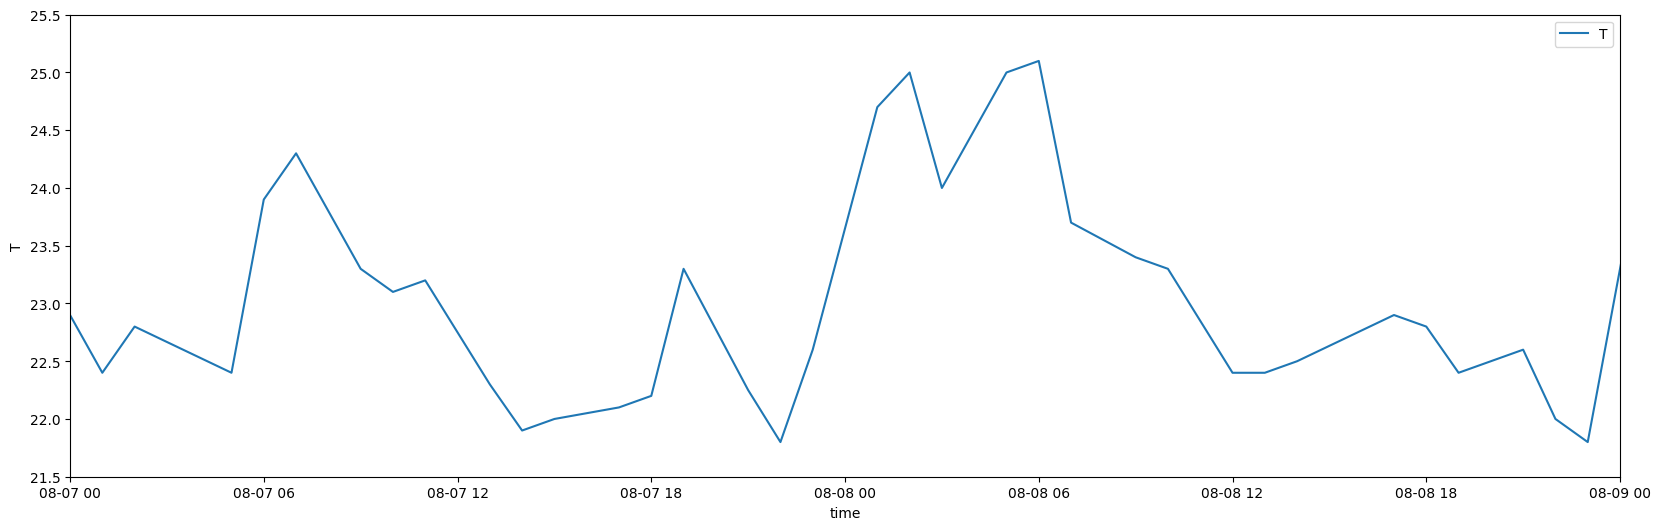

In [22]:
plt.figure(figsize=(20, 6))
plot = sns.lineplot(data=T_tsm._df, x='time', y='T', label='T')
plot.set_xlim([datetime(2023, 8, 7), datetime(2023, 8, 9)])
plot.set_ylim([21.5, 25.5])

In [23]:
T_predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.859653,0.028402,0.409570,5
1,TemporalFusionTransformer,-0.859653,0.028402,168.739321,2
2,PatchTST,-1.000351,0.015678,71.102216,4
3,DeepAR,-1.084193,0.342604,75.775989,3
4,DynamicOptimizedTheta,-1.576389,16.442401,18.126822,1


In [24]:
T_predictor.feature_importance()

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


,importance,stdev,n,p99_low,p99_high
dt,0.083195,0.000000e+00,5.0,0.083195,0.083195
median_t,0.163561,0.000000e+00,5.0,0.163561,0.163561
tm1,0.223187,3.103168e-17,5.0,0.223187,0.223187
tm2,0.050111,0.000000e+00,5.0,0.050111,0.050111
tm3,0.075091,0.000000e+00,5.0,0.075091,0.075091
tm4,0.018712,0.000000e+00,5.0,0.018712,0.018712
tm5,0.091151,0.000000e+00,5.0,0.091151,0.091151


## Absolute humidity

### Internal absolute humidity

ADF Statistic: -5.212
p-value: 8.293e-06
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
ADF Statistic: -9.381
p-value: 6.955e-16
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


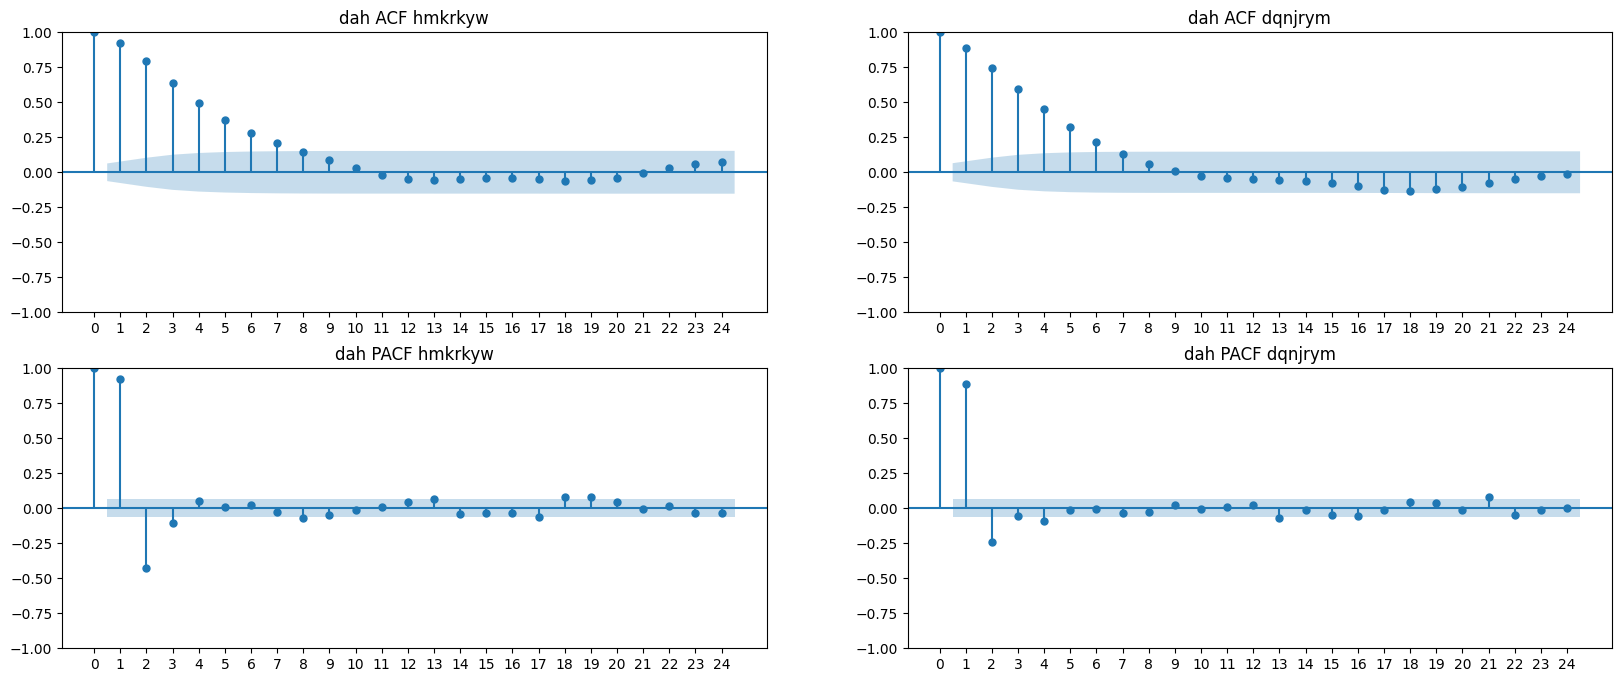

In [25]:
# Autocorrelation of the external absolute humidity ah
df_hmkrkyw_dah = remove_daily_trend(df_hmkrkyw,'ah','dah')
df_dqnjrym_dah = remove_daily_trend(df_dqnjrym,'ah','dah')
adfuller_test(df_hmkrkyw_dah['dah'])
adfuller_test(df_dqnjrym_dah['dah'])
plot_acf_pacf([df_hmkrkyw_dah,df_dqnjrym_dah],['hmkrkyw','dqnjrym'],'dah')

### External absolute humidity

ADF Statistic: -5.212
p-value: 8.293e-06
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
ADF Statistic: -9.381
p-value: 6.955e-16
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


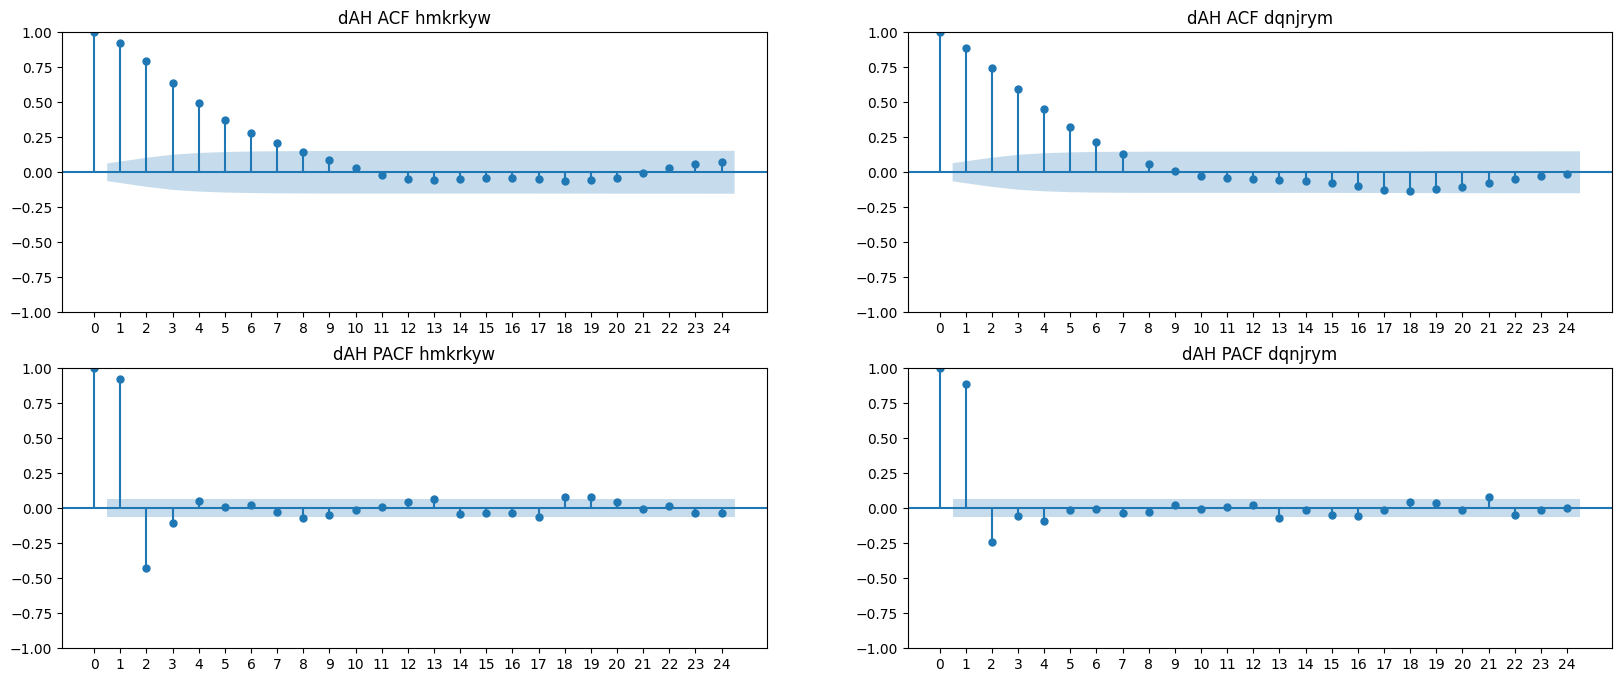

In [26]:
# Autocorrelation of the external absolute humidity ah
df_hmkrkyw_dAH = remove_daily_trend(df_hmkrkyw,'ah','dAH')
df_dqnjrym_dAH = remove_daily_trend(df_dqnjrym,'ah','dAH')
adfuller_test(df_hmkrkyw_dAH['dAH'])
adfuller_test(df_dqnjrym_dAH['dAH'])
plot_acf_pacf([df_hmkrkyw_dAH,df_dqnjrym_dAH],['hmkrkyw','dqnjrym'],'dAH')

In [27]:
# excluded_features = ['date','day_of_production','hour','ET','RH','T','t_ET','t_T','t_RH','t_AS','et','t','rh','pc','median_ah','weight','p']
excluded_features = ['date','day_of_production','hour','ET','RH','T','t_ET','t_T','t_RH','t_AS','et','t','rh','AS','CO2']
path="AG-AH-hourly"
lag = 3

target_feature = 'AH'
AH_tsm = TimeSeriesModel(features=specs,target_feature=target_feature,excluded_model_types=None,path=path)
AH_tsm.set_dataset(data_sets,lag,excluded_features,cutoff)
AH_predictor = AH_tsm.model()

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to 'AG-AH-hourly'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          22
GPU Count:          1
Memory Avail:       14.58 GB / 31.51 GB (46.3%)
Disk Space Avail:   618.06 GB / 932.06 GB (66.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['ah',
                            'ahm1',
                            'ahm2',
                            'ahm3',
                            'dah',
                            'median_ah',
                            'p',
                            'pc',
                            'wd',
                            'weight',
                            'ws'],
 'num_val_windows': 2,
 'pre

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	Time limit exceeded... Skipping Chronos[base].
Training timeseries model TemporalFusionTransformer. Training for up to 132.7s of the 530.7s of remaining time.
	-1.7743       = Validation score (-RMSE)
	92.79   s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 145.9s of the 437.8s of remaining time.
	-1.4213       = Validation score (-RMSE)
	68.34   s     = Training runtime
	0.25    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 184.6s of the 369.2s of remaining time.
	-1.6610       = Validation score (-RMSE)
	78.97   s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 0.67, 'PatchTST': 0.33}
	-1.3326       = Validation score (-RMSE)
	1.01    s     = Training runtime
	0.27    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'DirectTabu

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


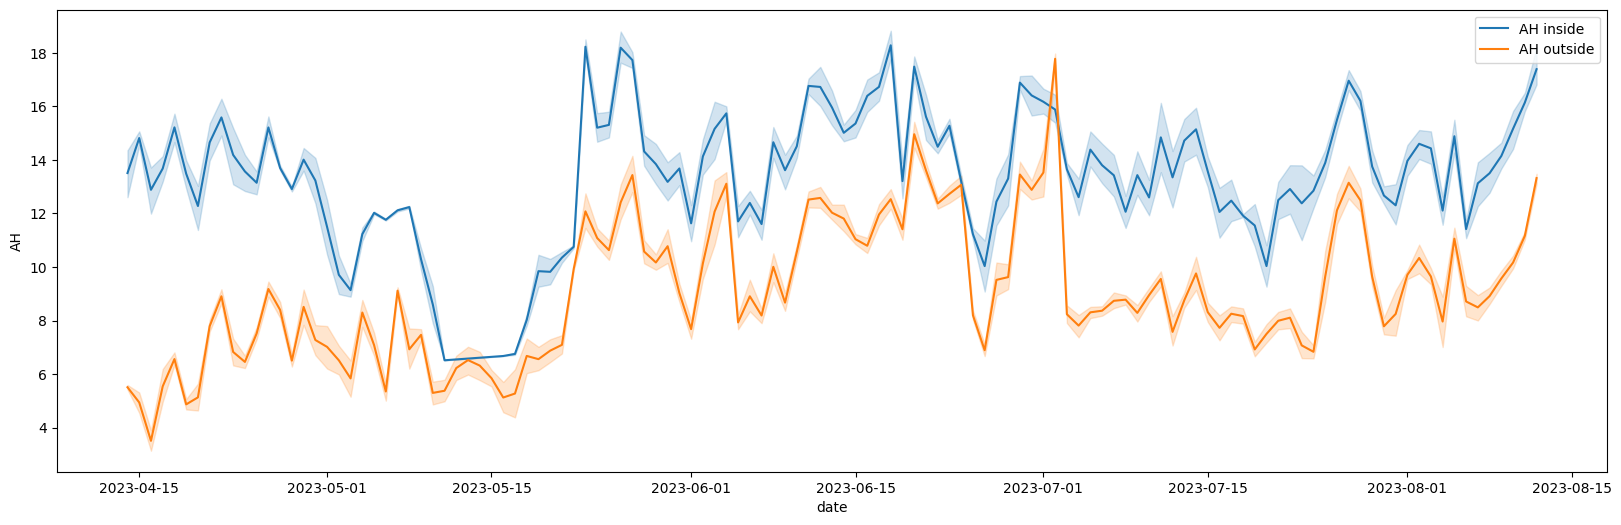

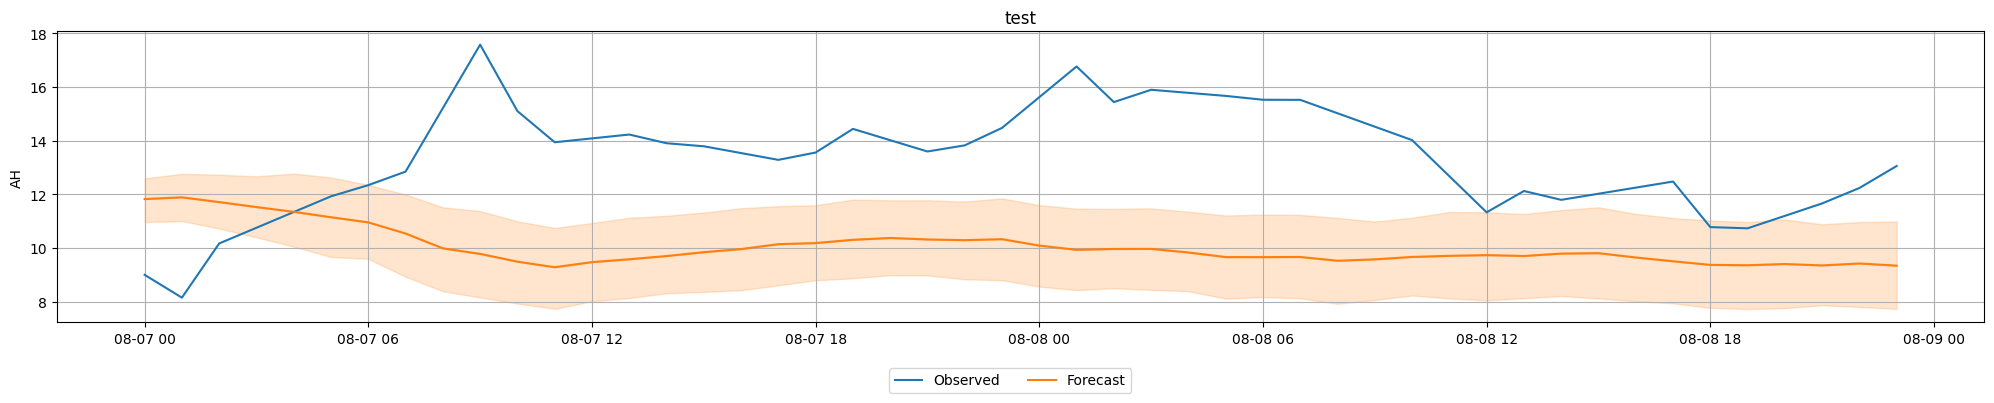

In [28]:
AH_predictions = AH_tsm.forecast(historic_steps=96)
AH_tsm.plot_forecast(AH_predictions)

In [29]:
AH_predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.332634,0.268749,1.006148,11
1,DeepAR,-1.421319,0.253749,68.344179,9
2,PatchTST,-1.661046,0.015000,78.970525,10
3,TemporalFusionTransformer,-1.774285,0.039068,92.789156,8
4,DirectTabular,-1.895080,0.122515,3.004988,2
5,NPTS,-1.974460,1.810493,1.727957,4
6,DynamicOptimizedTheta,-2.038107,16.765551,18.006103,5
7,AutoARIMA,-2.086850,14.225538,15.020798,7
8,CrostonSBA,-2.299945,6.846753,6.397549,3
9,AutoETS,-2.395713,16.081722,16.742986,6


In [30]:
AH_predictor.feature_importance()

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


,importance,stdev,n,p99_low,p99_high
ah,0.532610,0.008831,5.0,0.514427,0.550793
ahm1,0.268606,0.012221,5.0,0.243442,0.293770
ahm2,0.123341,0.012703,5.0,0.097185,0.149497
ahm3,0.068276,0.013641,5.0,0.040189,0.096363
dah,0.793971,0.010496,5.0,0.772360,0.815582
median_ah,-0.167128,0.012343,5.0,-0.192542,-0.141714
p,0.078487,0.009340,5.0,0.059255,0.097718
pc,0.014878,0.012883,5.0,-0.011649,0.041405
wd,0.080977,0.007082,5.0,0.066396,0.095558
weight,0.204453,0.014242,5.0,0.175128,0.233779


### Generating internal effective temperature from the predictions

In [31]:
def effective_temperature_for_weight_gain(t:float, rh:float, v:float)->float:
        """
        Calculates the effective temperature for weight gain based on the given parameters.

        Parameters:
        t (float): Dry bulb temperature in degrees Celsius.
        rh (float): Relative humidity as a percentage.
        v (float): Air speed in meters per second.

        Returns:
        float: The effective temperature for weight gain.

        References:
        - Effective Temperature for Poultry and Pigs in Hot Climate
            https://www.intechopen.com/books/animal-husbandry-and-nutrition/effective-temperature-for-poultry-and-pigs-in-hot-climate
            DOI: 10.5772/intechopen.72821
        - Tao and Xin work: https://pdfs.semanticscholar.org/ec37/8c494f7e80d4715dfcd1408a47ae7588cfa6.pdf
        """
        
        # Constants for weight gain parameters
        c = 0.15
        d = 41
        e = 1

        # Calculate the effective temperature for weight gain
        return 0.794 * t + 0.25 * wetbulb_temperature(t, rh) + 0.7 - c * (d - t) * (v**e-0.2**e)

def wetbulb_temperature(t:float, rh:float)->float:
    """
    Calculates the wet-bulb temperature using the Stull formula.
    
    Parameters:
    t (float): The dry-bulb temperature in degrees Celsius.
    rh (float): The relative humidity as a percentage.
    
    Returns:
    float: The wet-bulb temperature in degrees Celsius.
    
    References:
    - Stull formula; see https://journals.ametsoc.org/doi/10.1175/JAMC-D-11-0143.1
    """
    # Stull formula	Tw = T * arctan[0.151977 * (rh% + 8.313659)^(1/2)] + arctan(T + rh%) - arctan(rh% - 1.676331) + 0.00391838 *(rh%)^(3/2) * arctan(0.023101 * rh%) - 4.686035
    return t*np.arctan(0.151977*(rh + 8.313659)**0.5)+np.arctan(t+rh)-np.arctan(rh-1.676331)+0.00391838*(rh)**1.5*np.arctan(0.023101*rh)-4.686035

In [32]:
# Get start day_of_production
if isinstance(T_predictions.index,pd.MultiIndex):
    T_predictions = T_predictions.loc['test']
T_predictions.index = T_predictions.original_time

if isinstance(AH_predictions.index,pd.MultiIndex):
    AH_predictions = AH_predictions.loc['test']
AH_predictions.index = AH_predictions.original_time


df_predict = df_kkeesgc.join(T_predictions['mean'],how='right',rsuffix='_T').join(AH_predictions['mean'],how='right',lsuffix='_T',rsuffix='_AH')
df_predict.rename(columns={'mean_T':'T_predict','mean_AH':'AH_predict'},inplace=True)
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2022-07-01 10:00:00 to 2022-07-03 09:00:00
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               48 non-null     object 
 1   hour               48 non-null     int32  
 2   day_of_production  48 non-null     int64  
 3   ET                 48 non-null     float64
 4   T                  48 non-null     float64
 5   RH                 48 non-null     float64
 6   AH                 48 non-null     float64
 7   AS                 48 non-null     float64
 8   CO2                48 non-null     float64
 9   weight             48 non-null     float64
 10  et                 48 non-null     float64
 11  t                  48 non-null     float64
 12  rh                 48 non-null     int64  
 13  ah                 48 non-null     float64
 14  ws                 48 non-null     float64
 15  wd                 48 non-null     int

In [33]:
df_predict['RH_predict'] = df_predict.apply(lambda x: calculate_relative_humidity(x['p'],x['T_predict'],x['AH_predict']),axis=1)
df_predict['ET_predict'] = df_predict.apply(lambda x: effective_temperature_for_weight_gain(x['T_predict'],x['RH_predict'],x['AS']),axis=1)
df_predict.sample(10)

,date,hour,day_of_production,ET,T,RH,AH,AS,CO2,weight,...,pc,p,t_ET,t_T,t_RH,t_AS,T_predict,AH_predict,RH_predict,ET_predict
original_time,,,,,,,,,,,,,,,,,,,,,
2022-07-02 04:00:00,2022-07-02,4,36,23.077322,22.200000,69.000000,13.554930,0.100000,673.000000,2290.0,...,0.0,1018.76,23.414794,22.857143,65.0,0.2,21.503220,10.190044,53.757690,21.944404
2022-07-01 23:00:00,2022-07-01,23,35,22.489216,22.300000,72.000000,14.225839,0.300000,555.000000,2194.0,...,0.0,1019.24,23.560926,23.000000,65.0,0.2,23.617304,9.617766,44.945042,23.201799
2022-07-02 12:00:00,2022-07-02,12,36,25.114456,25.000000,67.000000,15.434889,0.450000,558.000000,2290.0,...,0.0,1017.85,23.414794,22.857143,65.0,0.2,21.671167,9.971947,52.099110,21.039672
2022-07-02 17:00:00,2022-07-02,17,36,24.293896,23.700000,72.500000,15.518059,0.250000,525.000000,2290.0,...,0.0,1015.99,23.414794,22.857143,65.0,0.2,25.550259,9.670223,40.519620,25.101141
2022-07-01 20:00:00,2022-07-01,20,35,23.209759,23.100000,73.000000,15.099925,0.500000,476.000000,2194.0,...,0.0,1017.66,23.560926,23.000000,65.0,0.2,23.731226,9.478281,44.007494,22.763208
2022-07-03 02:00:00,2022-07-03,2,37,22.241480,22.766667,60.333333,12.246867,0.333333,614.333333,2386.0,...,0.0,1017.76,23.268662,22.714286,65.0,0.2,24.516531,9.638275,42.803208,23.949191
2022-07-03 01:00:00,2022-07-03,1,37,22.046365,22.633333,59.666667,12.019412,0.366667,588.666667,2386.0,...,0.0,1017.92,23.268662,22.714286,65.0,0.2,24.514692,9.820112,43.615247,23.897639
2022-07-01 18:00:00,2022-07-01,18,35,23.332363,23.800000,71.000000,15.209420,0.400000,509.500000,2194.0,...,0.0,1016.25,23.560926,23.000000,65.0,0.2,23.981686,10.000961,45.778962,23.350093
2022-07-01 21:00:00,2022-07-01,21,35,22.585066,23.200000,67.000000,13.938185,0.400000,459.000000,2194.0,...,0.0,1018.37,23.560926,23.000000,65.0,0.2,23.691339,9.264617,43.112981,22.945984


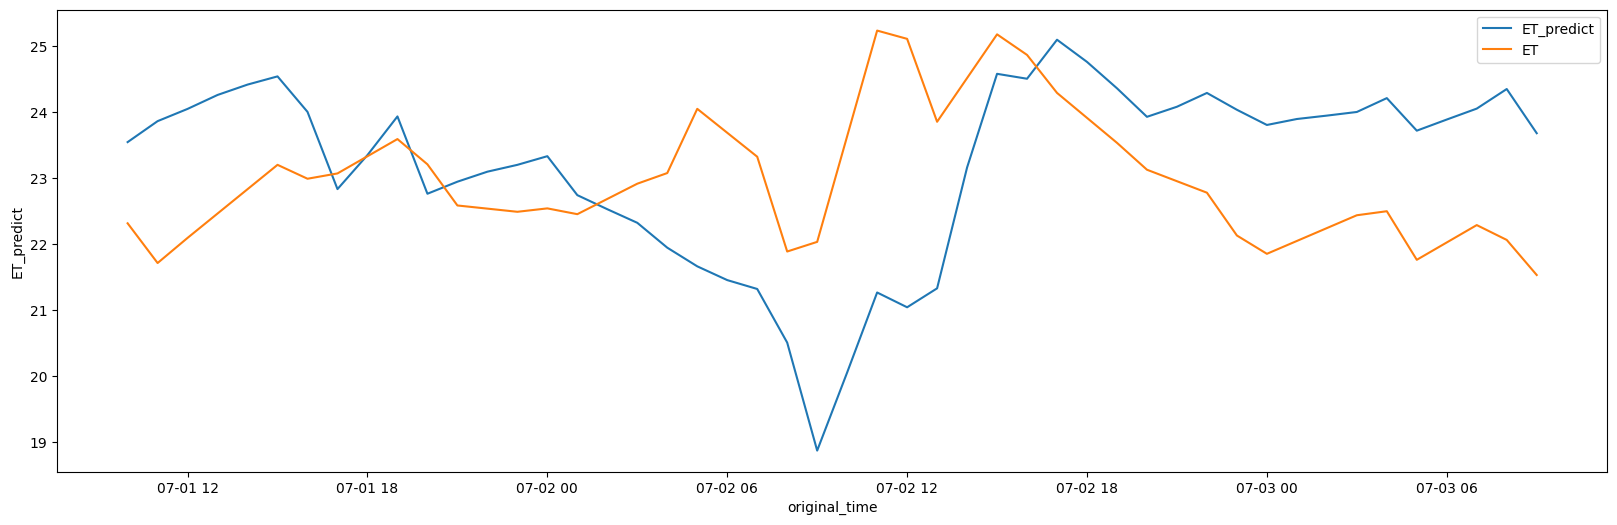

In [34]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_predict,x=df_predict.index,y='ET_predict',label='ET_predict')
sns.lineplot(data=df_predict,x=df_predict.index,y='ET',label='ET');

In [35]:
RMSE = np.sqrt(mean_squared_error(df_predict['ET'],df_predict['ET_predict']))
print(f"RMSE: {RMSE:.2f}")

RMSE: 1.76


# Non-linear regression analysis

As an alternative method to the above timeseries forecasting, we can understand this as a (non-linear) regression problem and use tree-based methods to predict effective temperature. Given that multi-collinearity is not an issue for tree-based methods, it makes sense to model the effective temperature directly.

We will use the first two flocks to train the model and the third flock to test the model. The model will be trained to predict the effective temperature ET. 

Given the results from the ACF and PACF plots and the earlier analysis of linear regression, we will use the following features to train the model:  
- $t_{t}$ - $t_{t-5}$
- $rh_{t}$ - $rh_{t-2}$
- $wd$
- $pc$
- $p$
- weight
    
We expect to reduce the feature set significantly later in the process using feature importance.

We will assume that it is not the time that is relevant for prediction, but rather the day_of_production and (maybe) the hour of the day. 

In [36]:
start_dt = T_predictions.index[0]
end_dt = T_predictions.index[-1]
df = pd.concat([df_hmkrkyw,df_dqnjrym])
# And now the test data
df_train = pd.concat([df,df_kkeesgc[df_kkeesgc.index < start_dt]])
df_test = df_kkeesgc.loc[df_kkeesgc.index >= start_dt]
df_test = df_test.iloc[:len(T_predictions)]

In [37]:
def add_shifted_features(df:pd.DataFrame,T_lags:int=5,t_lags:int=5,RH_lags:int=2,rh_lags:int=2)->pd.DataFrame:
    # add columns for shifted values of some of the features
    #df = TimeSeriesModel.shift_feature(df,'ET',range(1,T_lags+1))
    df = TimeSeriesModel.shift_feature(df,'t',range(1,t_lags+1))
    # df = TimeSeriesModel.shift_feature(df,'RH',range(1,RH_lags+1))    
    df = TimeSeriesModel.shift_feature(df,'rh',range(1,rh_lags+1))
    return df    

In [38]:
df_train = add_shifted_features(df_train,T_lags=5,t_lags=5,RH_lags=2,rh_lags=2)
df_test = add_shifted_features(df_test,T_lags=5,t_lags=5,RH_lags=2,rh_lags=2)

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2712 entries, 2022-08-04 12:00:00 to 2022-07-01 09:00:00
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               2712 non-null   object 
 1   hour               2712 non-null   int32  
 2   day_of_production  2712 non-null   int64  
 3   ET                 2712 non-null   float64
 4   T                  2712 non-null   float64
 5   RH                 2712 non-null   float64
 6   AH                 2712 non-null   float64
 7   AS                 2712 non-null   float64
 8   CO2                2712 non-null   float64
 9   weight             2712 non-null   float64
 10  et                 2712 non-null   float64
 11  t                  2712 non-null   float64
 12  rh                 2712 non-null   float64
 13  ah                 2712 non-null   float64
 14  ws                 2712 non-null   float64
 15  wd                 2712 non-null   f

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2022-07-01 10:00:00 to 2022-07-03 09:00:00
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               48 non-null     object 
 1   hour               48 non-null     int32  
 2   day_of_production  48 non-null     int64  
 3   ET                 48 non-null     float64
 4   T                  48 non-null     float64
 5   RH                 48 non-null     float64
 6   AH                 48 non-null     float64
 7   AS                 48 non-null     float64
 8   CO2                48 non-null     float64
 9   weight             48 non-null     float64
 10  et                 48 non-null     float64
 11  t                  48 non-null     float64
 12  rh                 48 non-null     int64  
 13  ah                 48 non-null     float64
 14  ws                 48 non-null     float64
 15  wd                 48 non-null     int

In [41]:
# Now drop the ones we do not need
excluded_features = ['date','time','RH','AH','T','AS','CO2','t_ET','et','ah','day_of_production','t_T','t_RH','t_AS','pc']
df_train = df_train.reset_index().drop(columns=excluded_features)
df_test  = df_test.reset_index().drop(columns=excluded_features)

In [42]:
# Fixing the random state
random_state = 42
# We will use 20% of the data for testing
test_size = 0.2


def init_random_state(random_state:int=42):
    """Simple method to set the random state for reproducibility

    Args:
        random_state (int, optional): An integer seed. Defaults to 42.
    """
    random.seed(1)
    np.random.seed(1)
    try:
        # If tensorflow is imported (as tf), also set tensorflow's random seed
        tf.random.set_seed(1)
    except:
        pass

In [43]:
def fit_model(regressor: Callable, X_train: pd.DataFrame, y_train: pd.Series, class_weight: [dict,str]=None, 
              sample_weight: pd.Series=None, optimisation_params: dict=None, model_params: dict=None, fit_params: dict=None,
              n_jobs:[int,None]=None, random_state:int=-1, verbose:int=0):
    """
    Fit a classifier and return the model and the predictions on the test set

    classifier: a classifier function
    X_train: training data set
    y_train: training labels
    X_test: test data set
    y_test: test labels
    class_weight: class weights for the classifier
    params: hyperparameters for the classifier
    random_state: random state for the classifier
    verbose: verbosity level for the classifier
    plot: whether to plot the confusion matrix
    """
    init_random_state(random_state)

    if not model_params:
        model_params = {}

    if class_weight:
        model_params['class_weight'] = class_weight
    if random_state != -1:
        model_params['random_state'] = random_state
    # Now create the classifier with the full parameter set
    clf = regressor(**model_params)
    if optimisation_params:
        # For imbalanced data sets, we use stratified k-fold, else normal k-fold
        if class_weight:
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
        else:
            cv = 5
        # and perform a grid search
        model = GridSearchCV(clf, cv=5, param_grid=optimisation_params, n_jobs=n_jobs)
        # Fitting the model on the train data
        if fit_params:
            result = model.fit(X_train, y_train, sample_weight=sample_weight,**fit_params)
        else:
            result = model.fit(X_train, y_train, sample_weight=sample_weight)
        estimator = result.best_estimator_
    else:
        result = clf.fit(X_train, y_train)
        estimator = result
    
    return estimator

In [44]:
target_feature = 'ET'
# Create the training and testing sets
y_train = df_train[target_feature]
X_train = df_train.drop(columns=[target_feature])
y_test = df_test[target_feature]
X_test = df_test.drop(columns=[target_feature])

In [45]:
optimisation_params = {'n_estimators':[50,100,200],'max_depth':[4,6,8], 'learning_rate':[0.05,0.1,0.2]}
# Now fit the optimal model
xgb_model = fit_model(XGBRegressor, X_train, y_train, 
                      optimisation_params=optimisation_params, 
                      model_params={'eval_metric':'rmse'},random_state=random_state)

xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [46]:
xgb_model.score(X_train,y_train)

0.9432364031464983

In [48]:
optimisation_params = {'n_estimators':[50,100,200],'max_depth':[4,6,8], 'num_leaves':[2^4, 2^6, 2^8], 'learning_rate':[0.05,0.1,0.2]}
# Now fit the optimal model
lgm_model = fit_model(LGBMRegressor, X_train, y_train, 
                      optimisation_params=optimisation_params, 
                      model_params={'objective':'regression'},fit_params={'eval_metric':'rmse'},random_state=random_state)

lgm_model.get_params()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 2169, number of used features: 14
[LightGBM] [Info] Start training from score 26.391407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2785
[LightGBM] [Info] Number of data points in the train set: 2169, number of used features: 14
[LightGBM] [Info] Start training from score 27.222373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 2170, number of used features: 14
[LightGBM] [Info] Start trai

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 4,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [49]:
lgm_model.score(X_train,y_train)

0.9189395167300236

In [50]:
y_pred = xgb_model.predict(X_test)
df_test['ET_predict_XGB'] = y_pred
y_pred = lgm_model.predict(X_test)
df_test['ET_predict_LGM'] = y_pred
# Throw away the first point as we have no data for t-1
df_test = df_test.iloc[1:]

In [51]:
RMSE = np.sqrt(mean_squared_error(df_test['ET'],df_test['ET_predict_XGB']))
print(f"RMSE for XGB: {RMSE:.4f}")
RMSE = np.sqrt(mean_squared_error(df_test['ET'],df_test['ET_predict_LGM']))
print(f"RMSE for LightGBM: {RMSE:.4f}")

RMSE for XGB: 1.0510
RMSE for LightGBM: 0.8943


In [52]:
df_test['time'] = T_predictions.index[1:]

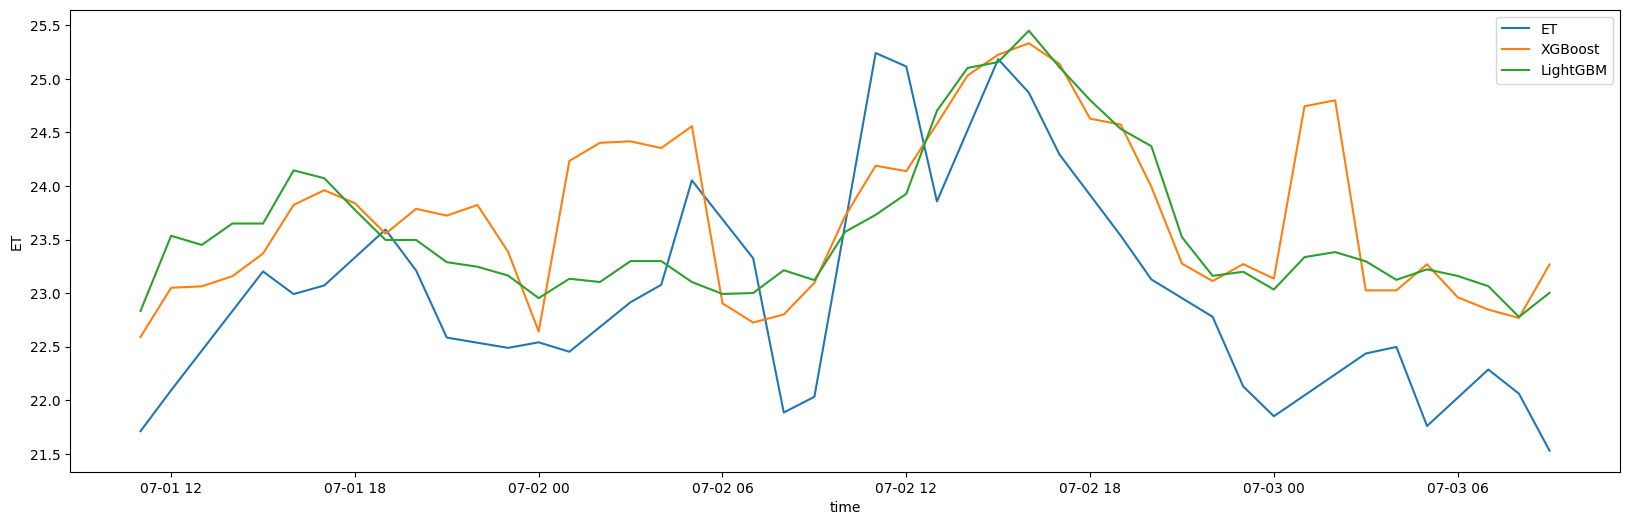

In [53]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_test,x='time',y='ET',label='ET')
sns.lineplot(data=df_test,x='time',y='ET_predict_XGB',label='XGBoost');
sns.lineplot(data=df_test,x='time',y='ET_predict_LGM',label='LightGBM');

In [54]:
explainer = shap.Explainer(xgb_model, X_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_train)

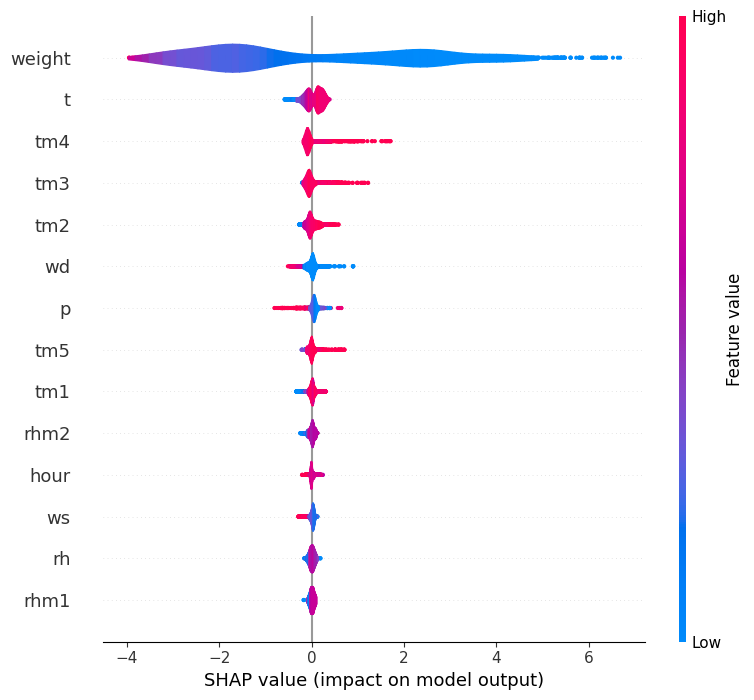

In [55]:
# And plot
shap.summary_plot(shap_values, plot_type='violin')

In [56]:
shap_values = pd.DataFrame(shap_values.values, columns=X_train.columns)
importance = {col:shap_values[col].abs().mean() for col in shap_values.columns}
importance = pd.DataFrame({'mean_sv':importance.values()}, index=importance.keys())
# normalise the importances
importance['mean_sv'] = importance['mean_sv']/importance['mean_sv'].sum()
# and sort them
importance = importance.sort_values(by='mean_sv', ascending=False)

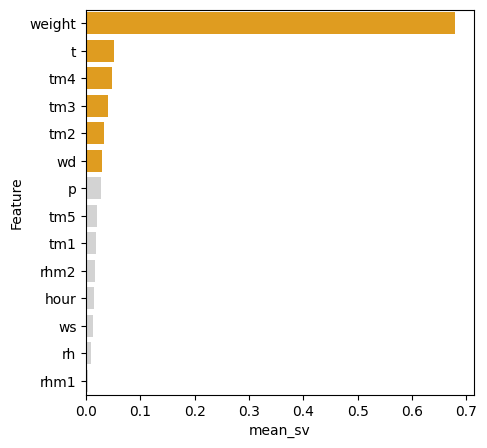

In [57]:
# Percentage of features to retain
feature_percentage = 0.90
# Now calculate the cumulative sum for cutoff
importance['cumulative'] = importance['mean_sv'].cumsum()
important_features = importance[importance.cumulative <= feature_percentage].index
feature_colors = ['orange' if feature in important_features else 'lightgrey' for feature in importance.index]

# Plot the importances
plt.figure(figsize = (5, 5))
ax = sns.barplot(x= importance.mean_sv, y=importance.index, palette=feature_colors)
ax.set_ylabel('Feature');

# Analysis of results and summary

<table>
    <tr>
        <td><img src="https://cdn-icons-png.flaticon.com/512/9746/9746435.png" alt="Success!" width="70%" height="auto"></td>
        <td>
        <h3><b>Mission accomplished - twice!</b></h3>
        Predicting an uncertain future is more complicated than interpolating using a (supposedly) complete model of the world. It is hardly surprising that the timeseries approach was not as successful as the regression approach - and what this really tells us is that the chicken barn is well approximated as a closed system. Surely, adding other, relevant parameters like the setpoint temperature or the heating/cooling activity would make our model a lot better, but as it stands, we are able to predict the inside temperature of the barn 12h in advance with only the weather variables at time <em>t ... t-5</em>. The root mean square error of the 12h prediction is about 1ºC [&cong; 2 ºF] which is smaller than the variation during a day and in different parts of the barn. The timeseries forecast had a root mean square error of 1.76, so was significantly higher. However, it both cases the target set in the problem statement (error < 2ºC) was met.</td>
    </tr>
    <tr>
        <td><img src="https://cdn3.iconfinder.com/data/icons/business-management-part-3-2/512/40-1024.png" alt="Next steps" width="70%" height="auto"></td>
        <td>
        <h3><b>Next steps</b></h3>
        The analysis would need to be redone on different prediction "slices"; it might also help decrease the error of the timeseries prediction if we predicted only a single period and then re-trained the model with the prediction until we reach 12h. However, computationally this would be quite demanding as AutoGluon is not fast (for obvious reasons) and it is not totally clear whether this is not already done internally by AutoGluon - the documentation is still catching up a bit.

After that, the next logical step would be to extend the training set to at least 2 flocks per season and then see how the prediction accuracy changes. </td>
    </tr>
    <tr>
        <td><img src="https://cdn-icons-png.flaticon.com/512/3930/3930474.png" alt="Improvements" width="70%" height="auto"></td>
        <td>
        <h3><b>Improvements</b></h3>
        There are many ways to improve this analysis, probably in both "branches". For the timeseries analysis, we have used AutoGluon out of the box without trying to optimise any of the underlying models. AutoGluon provides us with an ensemble model with consistently the best results, but it is not clear how to obtain the same model "manually". For the regression problem, a similiar statement is true - we have not optimised the model to the fullest (and only tried LightGBM and XGBoost).</td>
    </tr>
</table>





